## ⚙️ Import Libraries

### Invers Dual Unet - Multi Dynamic Loss - Usage of Transformer

In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

from datetime import datetime

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import ops
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

import seaborn as sns
import pandas as pd

import hashlib
from collections import defaultdict
import matplotlib.pyplot as plt

import keras_hub as kh

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 2


## ⏳ Load

In [2]:
data = np.load("/kaggle/input/mars-for-students/mars_for_students.npz")

training_set = data["training_set"]
X_train_val = training_set[:, 0]
y_train_val = training_set[:, 1]

X_test = data["test_set"]

input_shape = X_train_val.shape[1:]
num_classes = len(np.unique(y_train_val))

print(f"\nInput shape: {input_shape}")
print(f"Number of classes: {num_classes}")

print(f"\nShape of X_train: {X_train_val.shape}")
print(f"Shape of y_train: {y_train_val.shape}")
print(f"Shape of X_test: {X_test.shape}")


Input shape: (64, 128)
Number of classes: 5

Shape of X_train: (2615, 64, 128)
Shape of y_train: (2615, 64, 128)
Shape of X_test: (10022, 64, 128)


# Inspect Images

Training set images: 2615


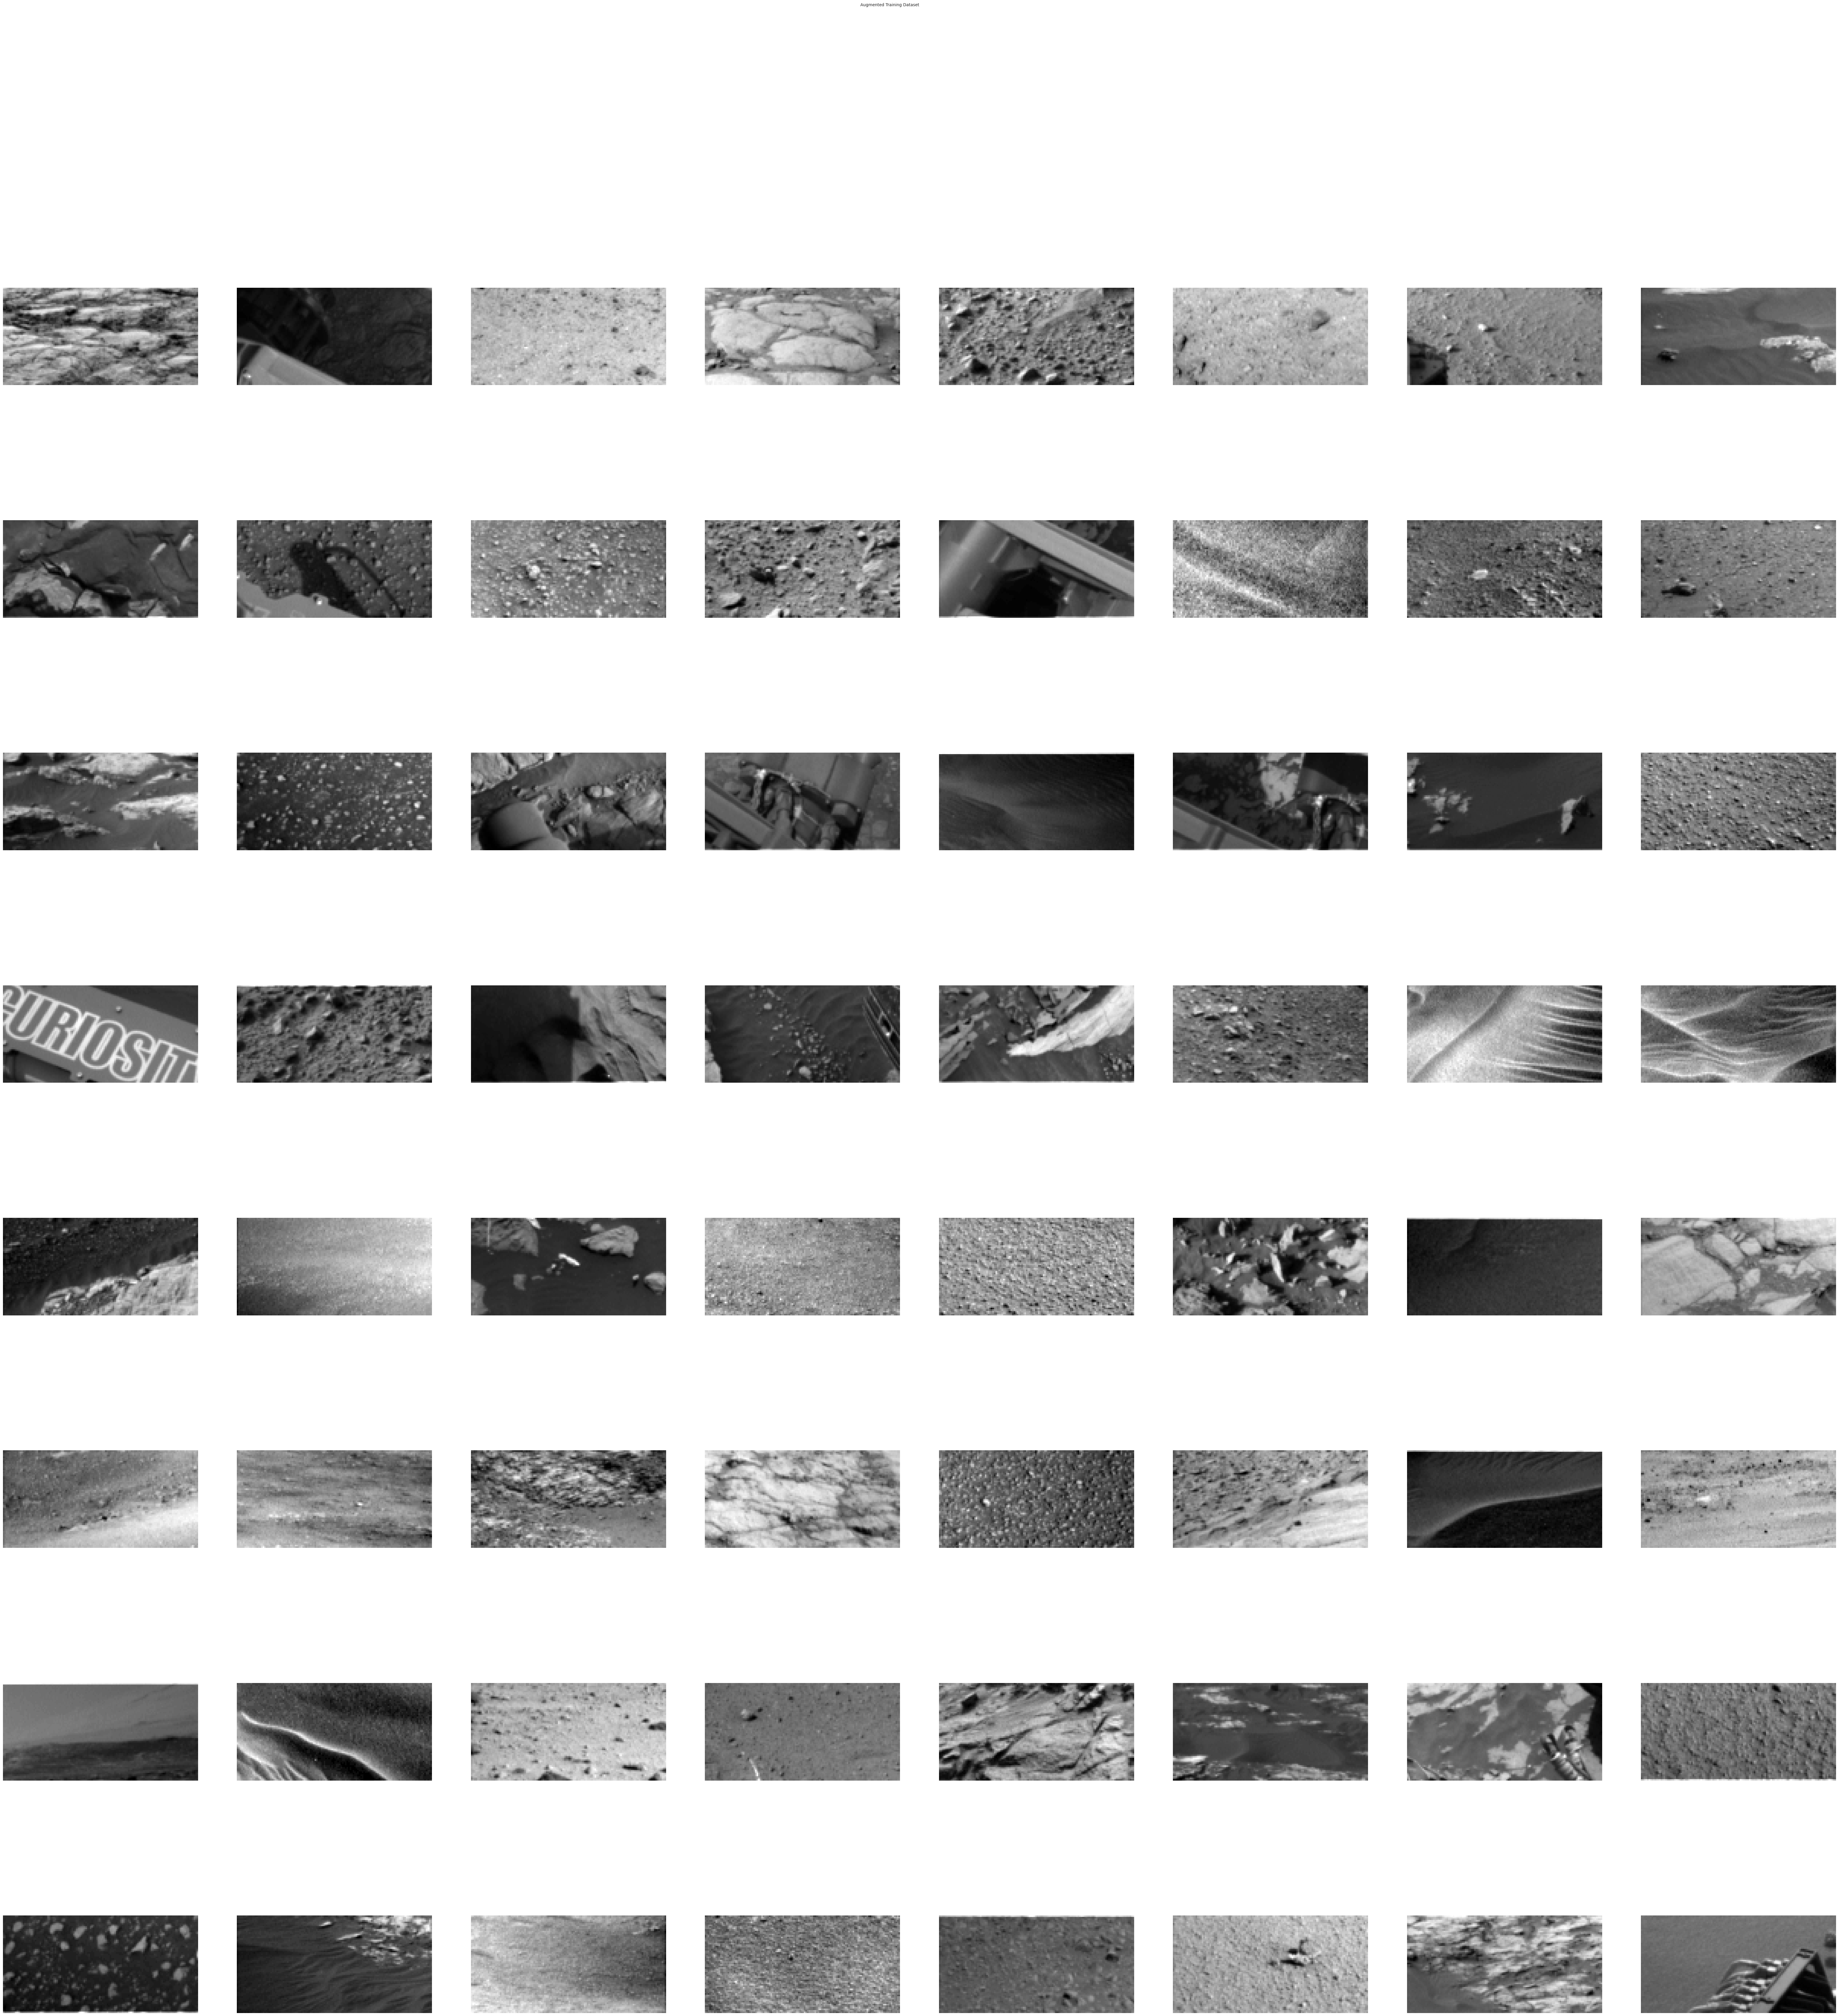

In [3]:
def visualize_dataset(dataset, title, image_size=(10, 10), grid_size=(8, 8)):
    print("Training set images:", len(dataset))

    num_images_to_plot = grid_size[0] * grid_size[1]
    random_indices = random.sample(range(len(dataset)), num_images_to_plot)
    sampled_images = [dataset[i] for i in random_indices]
    
    figsize = (grid_size[1] * image_size[0], grid_size[0] * image_size[1])
    plt.figure(figsize=figsize)
    plt.suptitle(title, fontsize=10)
    for i, image in enumerate(sampled_images):
        plt.subplot(grid_size[0], grid_size[1], i + 1)
        plt.imshow(image, cmap="gray")  # Grayscale visualization
        plt.axis("off")
    plt.show()

visualize_dataset(X_train_val, "Augmented Training Dataset")

## 👽 Detect Outliers

In [4]:
# Function to calculate the hash of an image
def calculate_image_hash(image):
    return hashlib.md5(image.tobytes()).hexdigest()

# Calculate hashes for each image and store their indices
hash_dict = defaultdict(list)
for idx, image in enumerate(y_train_val):
    img_hash = calculate_image_hash(image)
    hash_dict[img_hash].append(idx)

Duplicate images found!


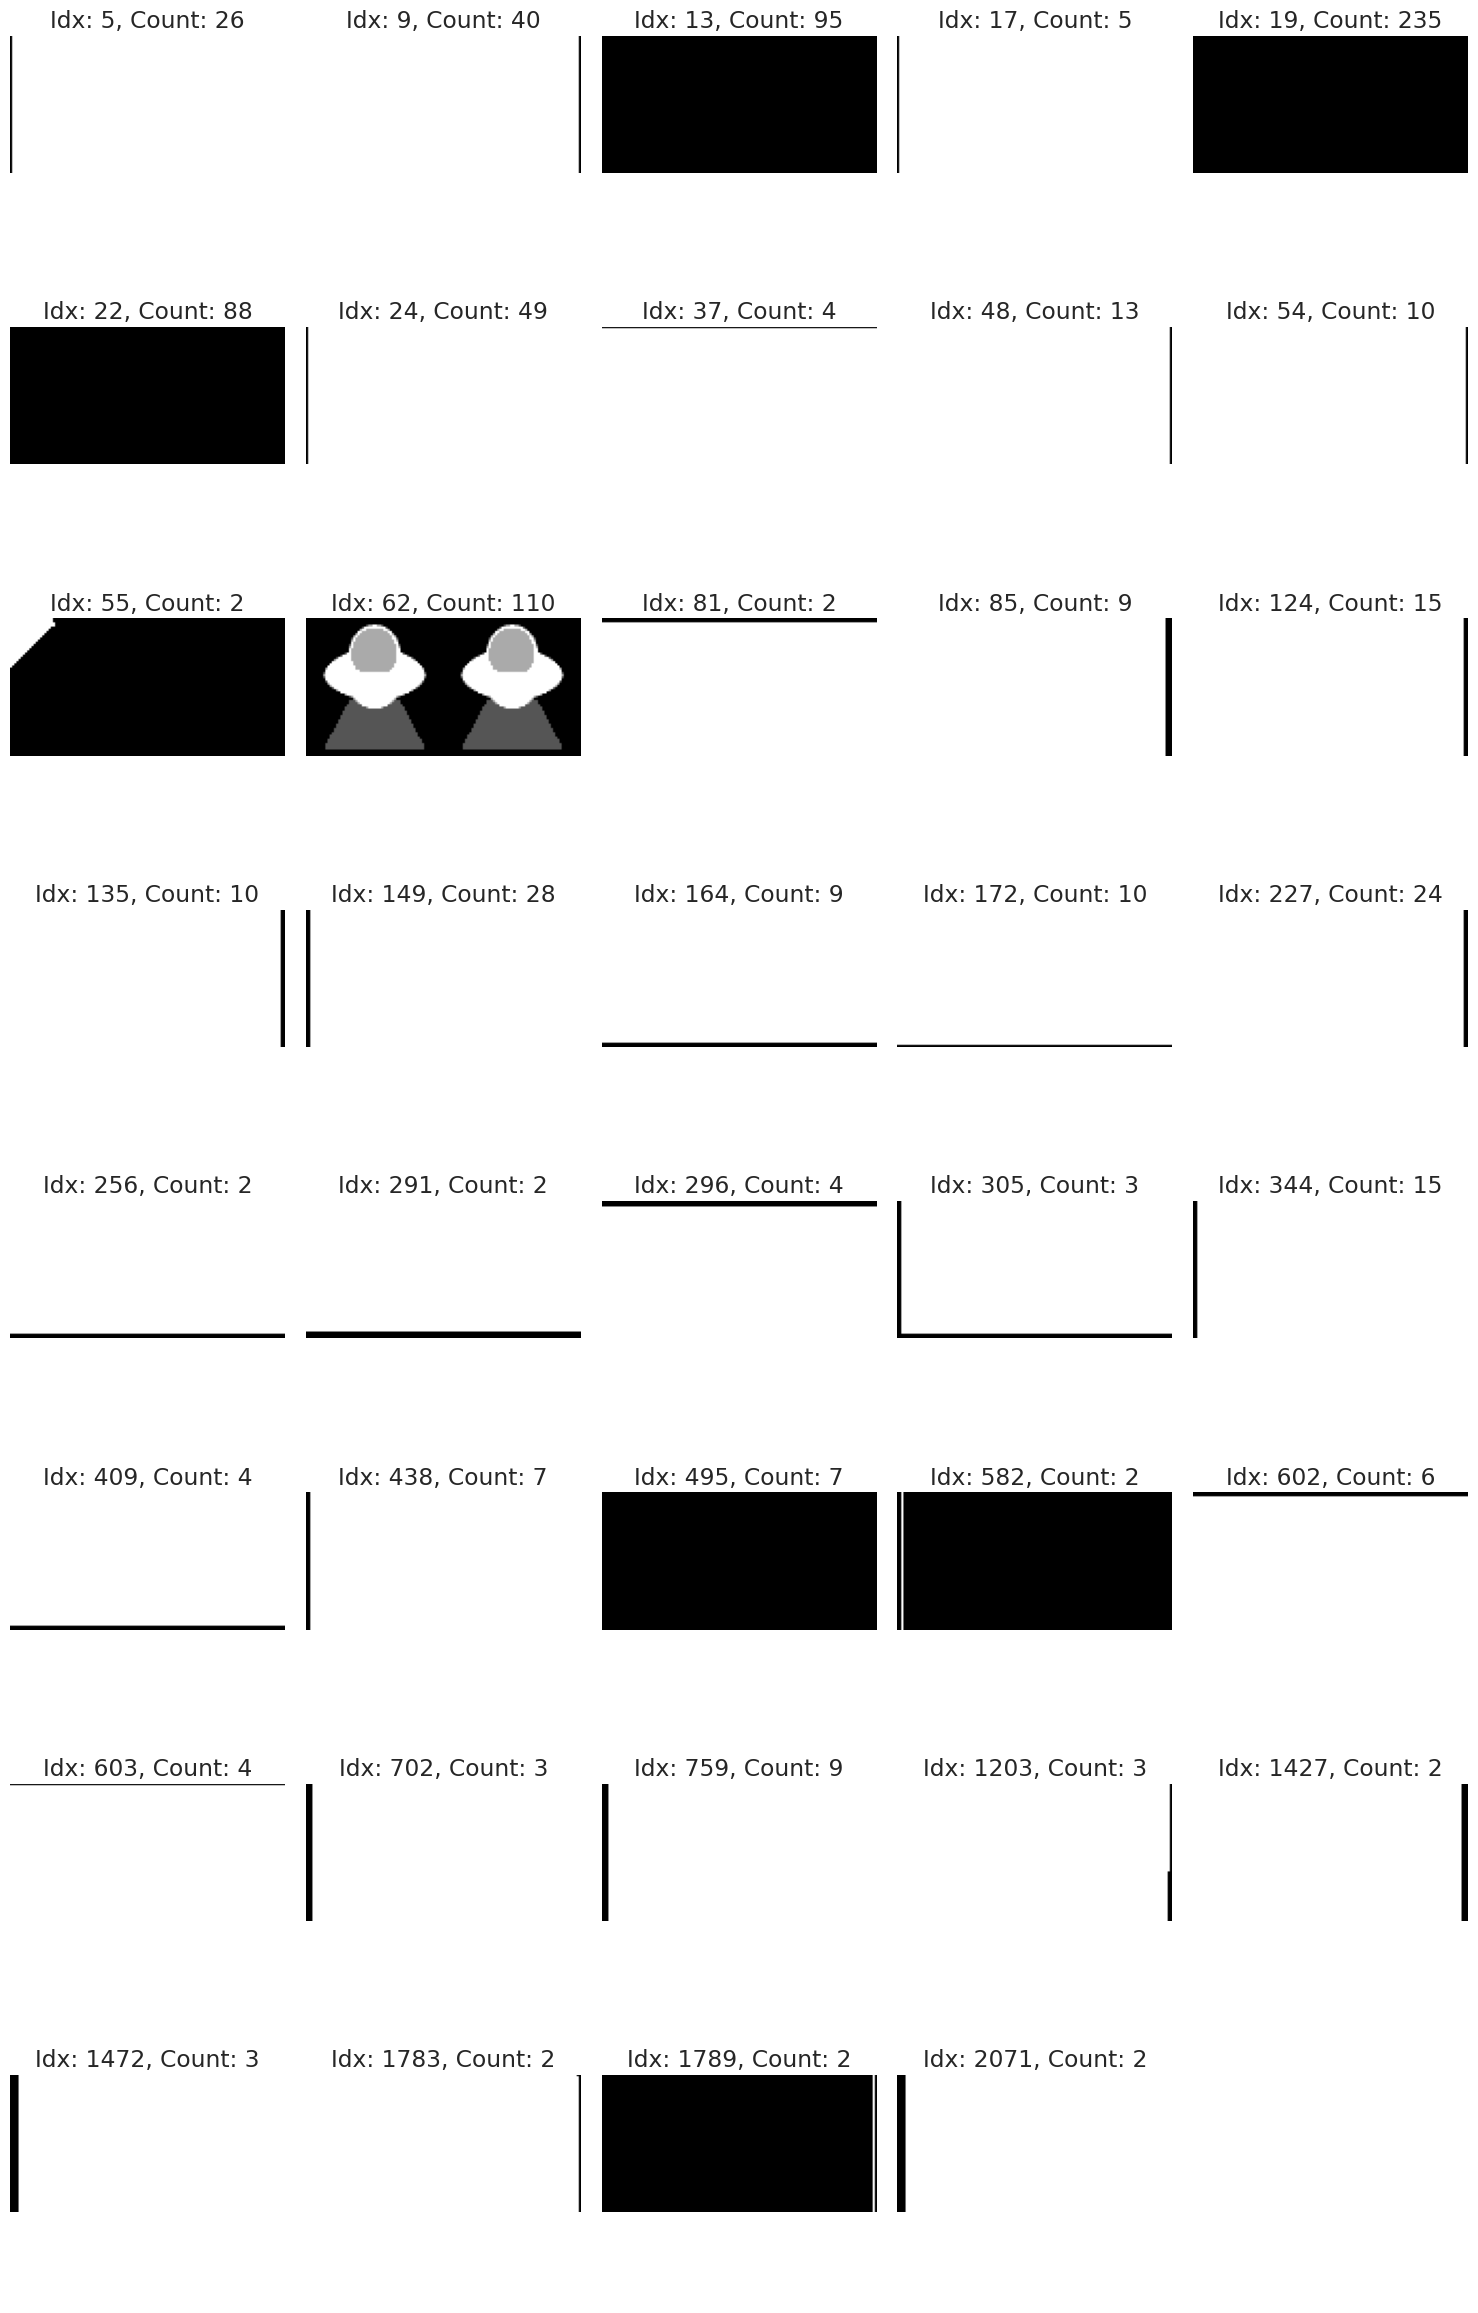

In [5]:
# Find duplicates
duplicates = {key: indices for key, indices in hash_dict.items() if len(indices) > 1}

if duplicates:
    print("Duplicate images found!")
   
    num_duplicates = len(duplicates)
    cols = 5 
    rows = (num_duplicates + cols - 1) // cols  
    
    # Create the figure and subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.flatten()  
    
    for i, (img_hash, indices) in enumerate(duplicates.items()):
        # Select one representative image
        representative_idx = indices[0]
        occurrence_count = len(indices)  
        ax = axes[i]
        
        # Plot the image
        if y_train_val[representative_idx].ndim == 3: 
            ax.imshow(y_train_val[representative_idx])
        else: 
            ax.imshow(y_train_val[representative_idx], cmap='gray')
        
        # Set title with hash, occurrences, and first index
        ax.set_title(f"Idx: {representative_idx}, Count: {occurrence_count}")
        ax.axis('off')
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

else:
    print("No duplicate images found!")

## Inspect an index

In [6]:
def create_segmentation_colormap(num_classes):
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

In [7]:
def apply_colormap(label, colormap=None):
    
    # Ensure label is 2D
    label = np.squeeze(label)

    # Ensure label values are in the valid range [0, num_classes-1]
    num_classes = len(colormap)  # Get the number of classes from the colormap
    label = np.clip(label, 0, num_classes - 1)  # Clip values to be within range

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

Hash for image at index 2071: 17fec901f6ed4082a70668bf7a334b37


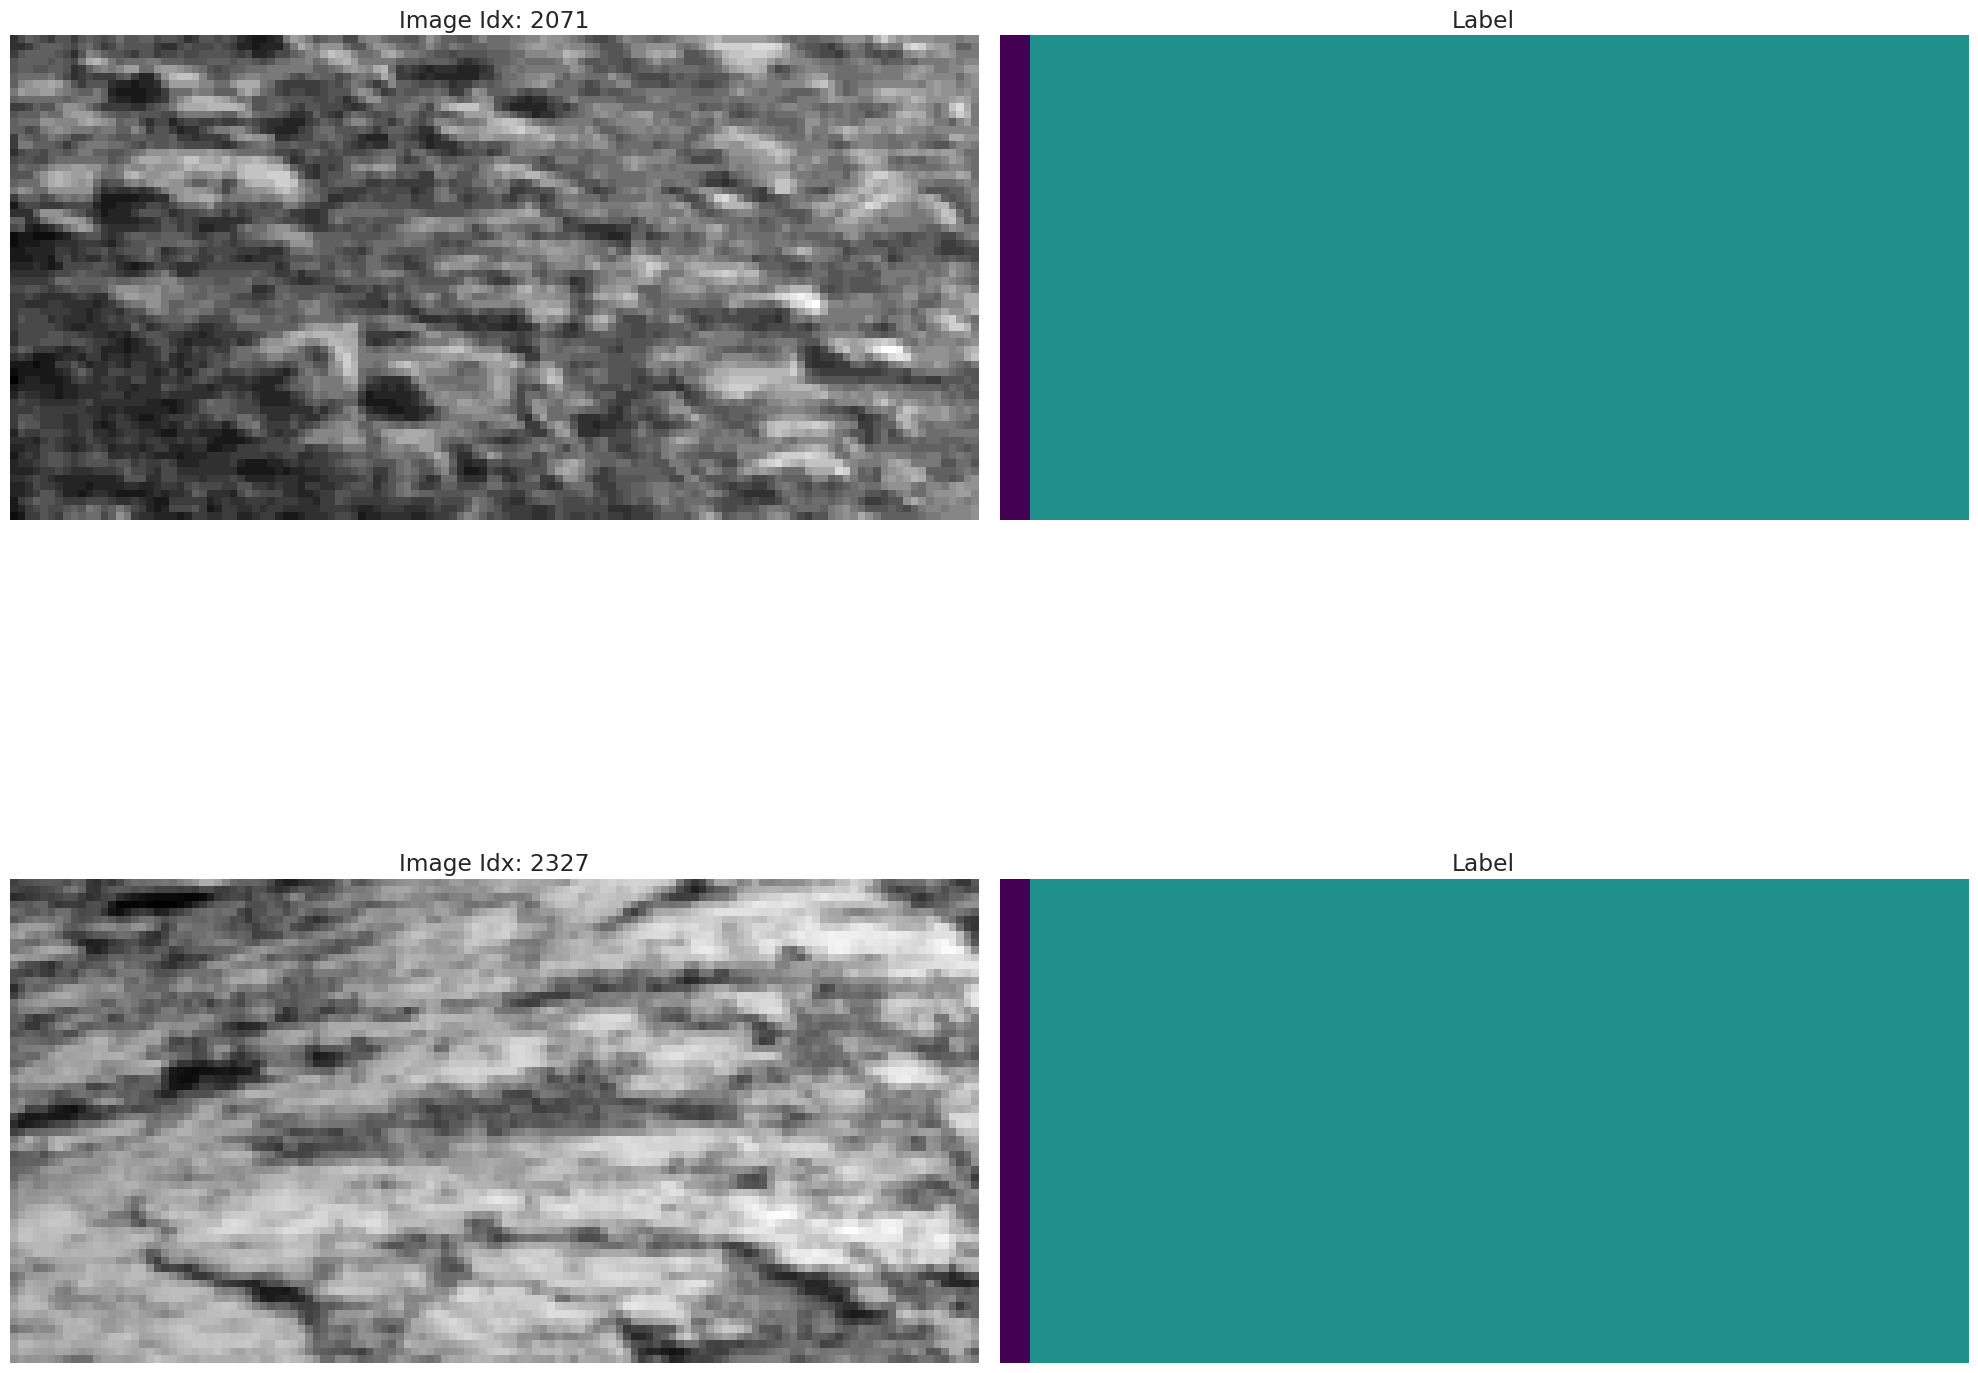

In [8]:
index_of_interest = 2071

# Function to get images associated with a specific index
def get_images_by_index(index):
    img_hash = calculate_image_hash(y_train_val[index])  # Calculate hash
    associated_indices = hash_dict.get(img_hash, [])  # Get duplicate indices
    return img_hash, associated_indices

# Get images and duplicates
img_hash, associated_indices = get_images_by_index(index_of_interest)

if associated_indices:
    print(f"Hash for image at index {index_of_interest}: {img_hash}")
    
    num_images = len(associated_indices)
    cols = 2  # Show image and label side-by-side
    rows = num_images  # One row per image-label pair
    
    # Create colormap for labels
    num_classes = len(np.unique(y_train_val))
    colormap = create_segmentation_colormap(num_classes)

    # Larger figure size for better visuals
    fig, axes = plt.subplots(rows, cols, figsize=(20, 10 * rows))
    axes = axes.reshape(rows, cols)  # Ensure axes is 2D for easy access

    for i, idx in enumerate(associated_indices):
        # Plot the image
        ax_image = axes[i, 0]
        ax_image.imshow(X_train_val[idx], cmap='gray' if X_train_val[idx].ndim == 2 else None)
        ax_image.set_title(f"Image Idx: {idx}")
        ax_image.axis('off')

        # Plot the label
        ax_label = axes[i, 1]
        colored_label = apply_colormap(y_train_val[idx], colormap)
        ax_label.imshow(colored_label)
        ax_label.set_title("Label")
        ax_label.axis('off')


    plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Adjust spacing
    plt.tight_layout()
    plt.show()

else:
    print(f"No duplicates found for image at index {index_of_interest}.")


In [9]:
alien_index = 62

# Get associated indices
img_hash, alin_associated_indices = get_images_by_index(alien_index)

if(X_train_val.shape[0] == 2615):
    X_train_val = np.delete(X_train_val, alin_associated_indices, axis=0)
    y_train_val = np.delete(y_train_val, alin_associated_indices, axis=0)
    print("Outliers removed")
else:
    print("Outliers already removed")

print("Dataset dimension:", X_train_val.shape)

Outliers removed
Dataset dimension: (2505, 64, 128)


## 🔄 Process Data

In [10]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 200

# Set data split size for training and validation
SPLITS_SIZE = 0.2

## dividing in train and validaiton set

In [11]:
# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=SPLITS_SIZE, random_state=seed
)

# Display dataset information
print(f"\nNumber of images:")
print(f"Training set: {len(X_train)}")
print(f"Validation set: {len(X_val)}")
print(f"Test set: {len(X_test)}")


Number of images:
Training set: 2004
Validation set: 501
Test set: 10022


In [12]:
# Define the category mapping
category_map = {
        0: 0,  # background
        1: 1,  # soil
        2: 2,  # bedrock
        3: 3,  # sand
        4: 4   # big rock
}

# Define the classes 
classes = ['background', 'soil', 'bedrock', 'sand', 'big rock'] 

NUM_CLASSES = len(set(category_map.values()))
print(f"Number of categories: {len(category_map)}")

Number of categories: 5


## normalizing the data

In [13]:
def preprocess_data(X, y, input_size=(64, 128)):
    X = tf.expand_dims(X, axis=-1)  
    X = tf.image.resize(X, input_size)
    X = tf.cast(X, tf.float32) / 255.0

    y = tf.expand_dims(y, axis=-1)
    y = tf.image.resize(y, input_size, method='bilinear')
    y = tf.cast(y, tf.int32)
    return X, y

# preprocessing also the test set
X_test = X_test[..., np.newaxis] / 255.0

In [14]:
def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

## defining augmentation

In [15]:
# Define augmentation
@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label


In [16]:
def make_dataset(X, y, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a TensorFlow dataset. 
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((X, y))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Preprocess immages and labels
    dataset = dataset.map(
        preprocess_data,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Apply category mapping: change the labels
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if augment: #apply random flip
        dataset = dataset.map(
            lambda x, y: random_flip(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Batch the data (do it now and not at training time)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [17]:
# Create the datasets
train_dataset = make_dataset(
    X_train, y_train, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False 
)

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break


Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128, 1)
Labels dtype: <dtype: 'int32'>


Visualizing examples from the training set:


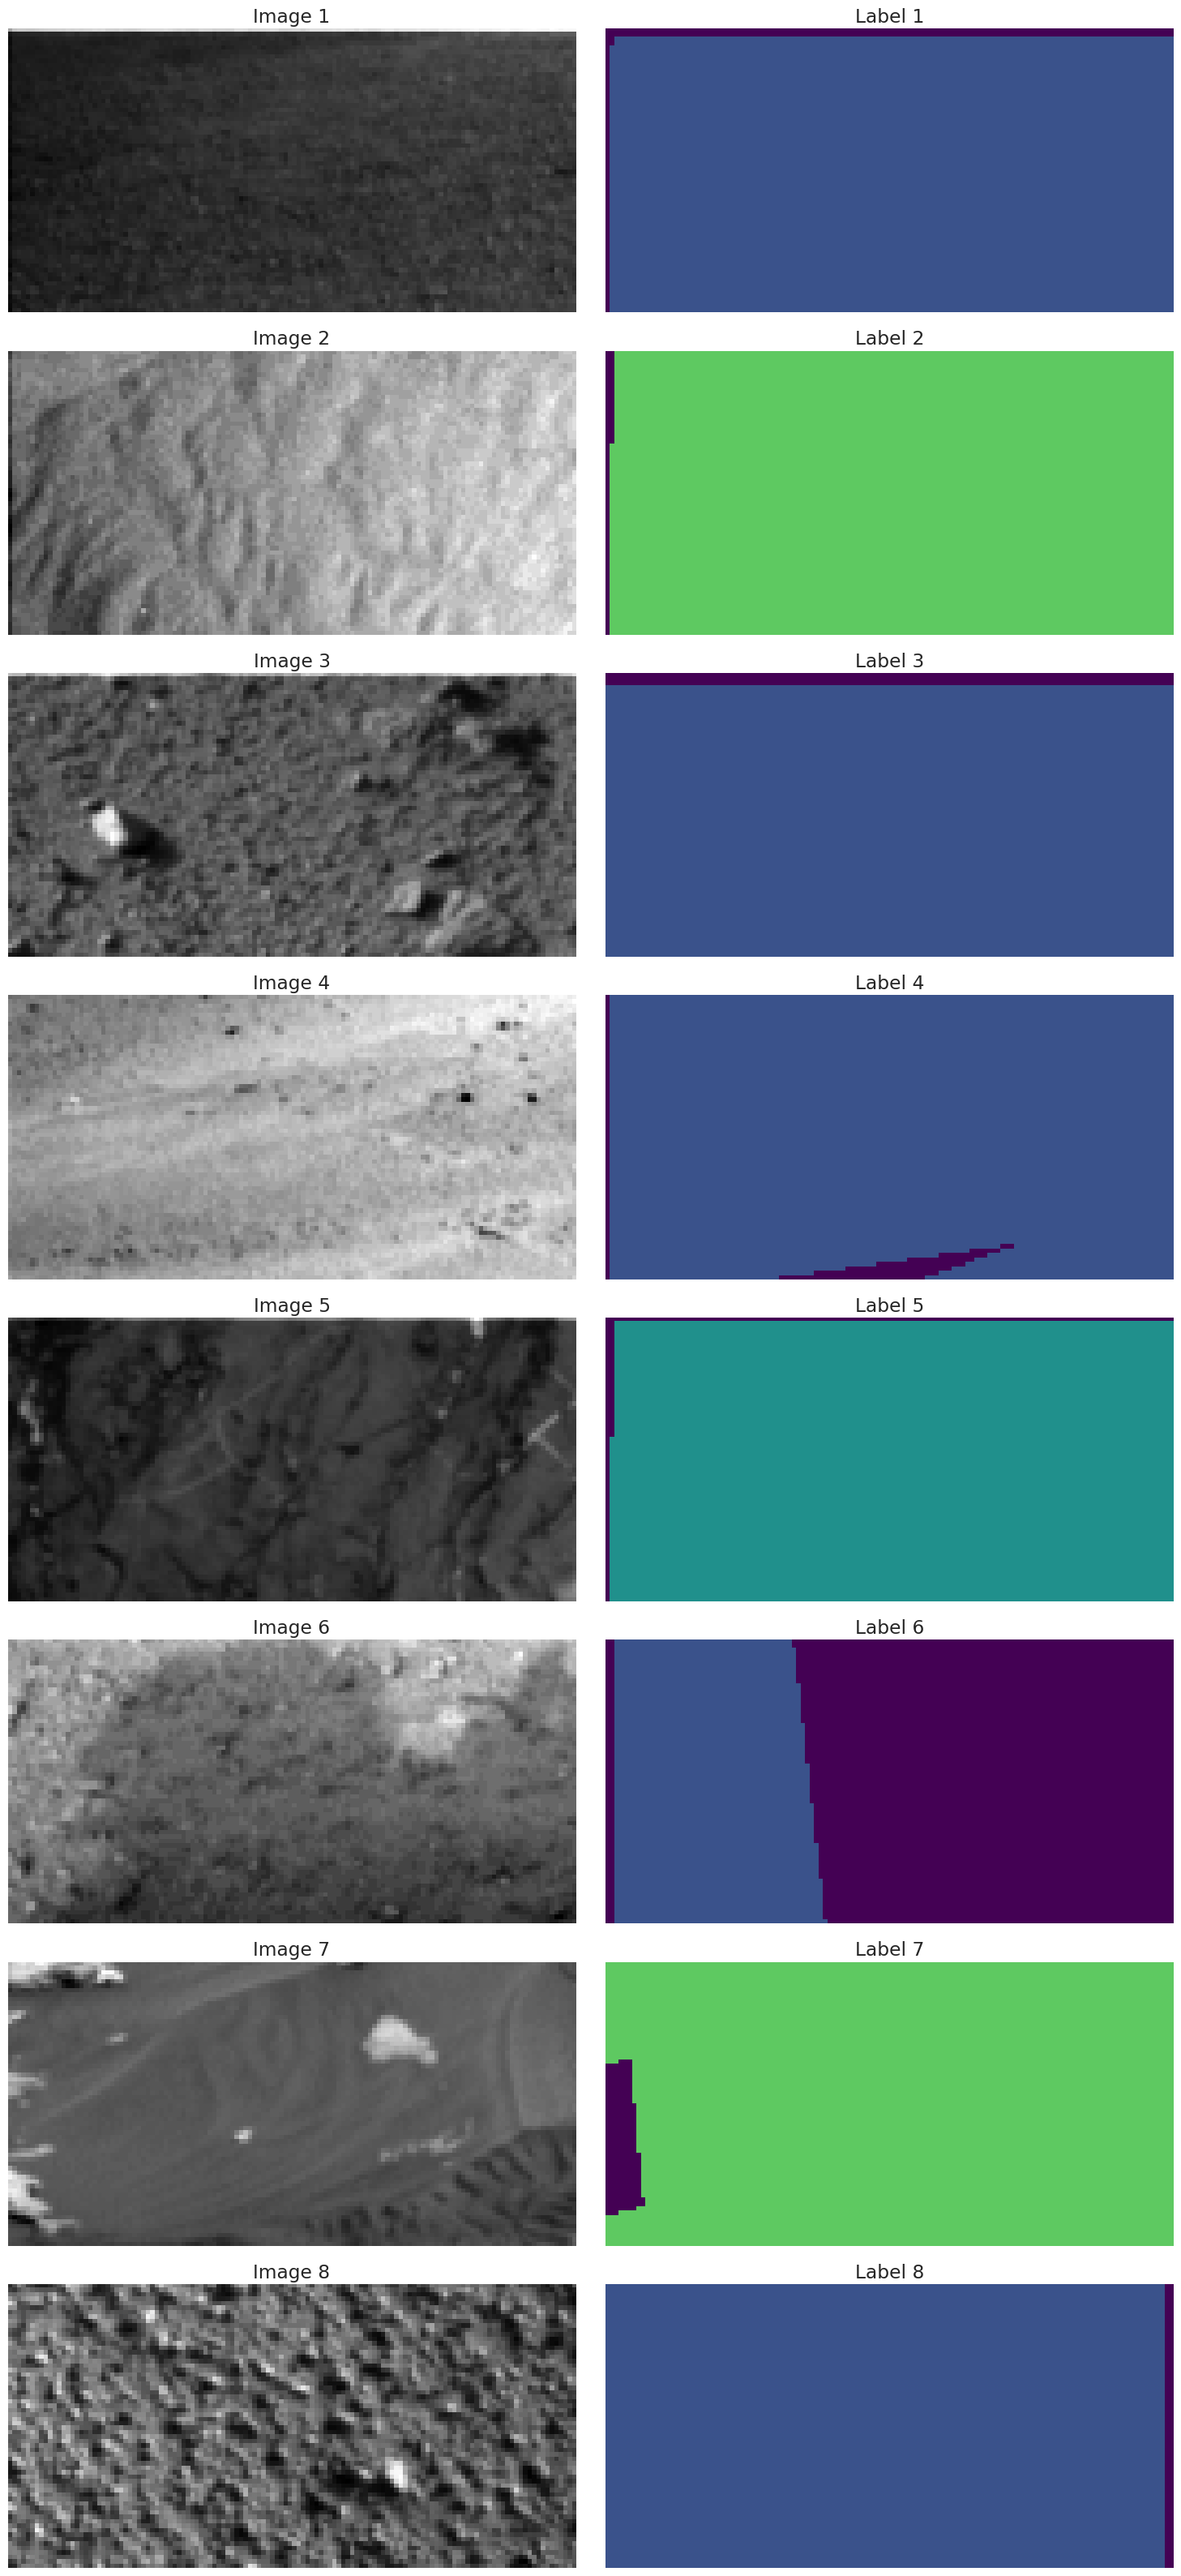

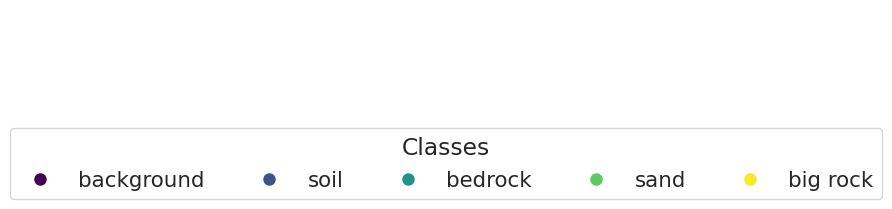

In [18]:
# Plot real image and ground truth (reduced resolution)
def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4 * num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(category_map)  # Ensure colormap covers all classes, including the background
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original grayscale image (no colormap)
            plt.subplot(num_samples, 2, j * 2 + 1)
            plt.imshow(images[j], cmap='gray')  # Use 'gray' cmap for the images (ensure grayscale)
            plt.title(f'Image {j + 1}')
            plt.axis('off')

            # Plot colored label (apply colormap only to labels)
            plt.subplot(num_samples, 2, j * 2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)  # Apply colormap to the labels only
            plt.imshow(colored_label)  # Show the colored label
            plt.title(f'Label {j + 1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

    handles = []
    # After all images have been plotted, add the legend once
    for label_idx in category_map:
        color = colormap[label_idx]  # Use array indexing, subtracting 1 to account for class 0 exclusion
        handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=classes[label_idx]))
    
    # Create a single legend displayed at the bottom
    fig, ax = plt.subplots(figsize=(10, 2))  # Make the figure wide enough for a horizontal legend
    ax.legend(handles=handles, loc='center', bbox_to_anchor=(0.5, 0), title="Classes", ncol=len(category_map))
    ax.axis('off')
    plt.show()

# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(train_dataset, num_samples=8)

## 🛠️ Model Definition and Training

In [19]:
# Conv2D Layer with BatchNorm and optional ReLU activation
@tf.keras.utils.register_keras_serializable()
class Conv2D(tf.keras.layers.Layer):
    def __init__(self, out_channels, kernel_size=3, padding="same", dilation=1, use_bias=False, activation=True):
        super().__init__()
        self.activation = activation
        self.conv = tfkl.Conv2D(out_channels, kernel_size, padding=padding, dilation_rate=dilation, use_bias=use_bias)
        self.bn = tfkl.BatchNormalization()
        self.relu = tfkl.ReLU()

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        if self.activation:
            x = self.relu(x)
        return x

# Squeeze-and-Excitation Block
@tf.keras.utils.register_keras_serializable()
class SqueezeExcitationBlock(tf.keras.layers.Layer):
    def __init__(self, in_channels, ratio=8):
        super().__init__()
        self.global_avg_pool = tfkl.GlobalAveragePooling2D()
        self.fc1 = tfkl.Dense(in_channels // ratio, activation="relu")
        self.fc2 = tfkl.Dense(in_channels, activation="softmax")

    def call(self, inputs):
        y = self.global_avg_pool(inputs)
        y = self.fc1(y)
        y = self.fc2(y)
        y = tf.reshape(y, (-1, 1, 1, inputs.shape[-1]))
        return inputs * y

# ASPP Module
@tf.keras.utils.register_keras_serializable()
class ASPP(tf.keras.layers.Layer):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.avgpool = tfk.models.Sequential([
            tfkl.GlobalAveragePooling2D(),
            tfkl.Reshape((1, 1, in_channels)),
            Conv2D(out_channels, kernel_size=1, padding="valid")
        ])
        self.conv1 = Conv2D(out_channels, kernel_size=1, padding="valid")
        self.conv2 = Conv2D(out_channels, kernel_size=3, padding="same", dilation=6)
        self.conv3 = Conv2D(out_channels, kernel_size=3, padding="same", dilation=12)
        self.conv4 = Conv2D(out_channels, kernel_size=3, padding="same", dilation=18)
        self.final_conv = Conv2D(out_channels, kernel_size=1, padding="valid")
        self.match_channel = Conv2D(in_channels, kernel_size=3, padding="valid")

    def call(self, inputs):
        # reshaping input to match the desired deepth
        if(self.in_channels != inputs.shape[3]):
            inputs = self.match_channel(inputs)
       # print("x",inputs.shape) # PRINT !!!!!!!!!!!!!!!!!!
        x0 = self.avgpool(inputs)
        x0 = tf.image.resize(x0, tf.shape(inputs)[1:3], method="bilinear")
        x1 = self.conv1(inputs)
        x2 = self.conv2(inputs)
        x3 = self.conv3(inputs)
        x4 = self.conv4(inputs)
        x_concat = tf.concat([x0, x1, x2, x3, x4], axis=-1)
        return self.final_conv(x_concat)

# Convolutional Block with SE block
@tf.keras.utils.register_keras_serializable()
class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = Conv2D(out_channels)
        self.conv2 = Conv2D(out_channels)
        self.se_block = SqueezeExcitationBlock(out_channels)

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        return self.se_block(x)

In [20]:
# Encoder2 Custom Implementation
@tf.keras.utils.register_keras_serializable()
class Encoder1(tf.keras.layers.Layer):
    def __init__(self, inputs=1, filters=[32,64,128,256], **kwargs):
        super().__init__(**kwargs)
        
        self.pool = tfkl.MaxPooling2D(pool_size=(2, 2))
        self.conv1 = ConvBlock(input, filters[0])
        self.convs = [ConvBlock(filters[i], filters[i+1]) for i in range(len(filters)-1)]

    def call(self, inputs):
        x = self.conv1(inputs)
        #print(x.shape) # PRINT !!!!!!!!!!!!!!!!!!
        skip_connections = [x]
        x = self.pool(x)
        #print(x.shape) # PRINT !!!!!!!!!!!!!!!!!!
        for conv in self.convs:
            x = conv(x)
            #print(x.shape) # PRINT !!!!!!!!!!!!!!!!!!
            skip_connections.append(x)
            x = self.pool(x)
            #print(x.shape) # PRINT !!!!!!!!!!!!!!!!!!
        return x, skip_connections[::-1]


In [21]:
# Transformer Block
@tf.keras.utils.register_keras_serializable()
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self,d_model=64, num_heads=8, num_transformer_blocks=4,input_shape=(4,8)):
        super().__init__()
        self.d_model = d_model
        self.in_channels = input_shape[2]
        self.num_transformer_blocks = num_transformer_blocks
        self.flatten = tfkl.Reshape((-1, d_model))
        self.att = tfkl.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.norm = tfkl.LayerNormalization()
        self.dense = tfkl.Dense(d_model, activation="relu")
        self.expand = tfkl.Reshape((input_shape[0], input_shape[1], self.d_model))
        self.match_channel = Conv2D(input_shape[2], kernel_size=3, padding="same")

    def call(self, x):
        if(self.in_channels != x.shape[3]):
            x = self.match_channel(x)
        x = self.flatten(x)
        for _ in range(self.num_transformer_blocks):
            x = self.norm(x)
            x = self.att(x, x)
            # add skip connection [before_norm, after att]
            x = self.norm(x)
            x = self.dense(x) # the classical uses a multilayer perceptron
             # add skip connection [before_norm, after dense]
        x = self.expand(x)
        #print("output",x.shape)
        return x

In [22]:
# Decoder Block
@tf.keras.utils.register_keras_serializable()
class Decoder1(tf.keras.layers.Layer):
    def __init__(self, skip_channel_sizes):
        super().__init__()
        self.upsample = tfkl.UpSampling2D(size=(2, 2), interpolation="bilinear")
        self.blocks = [
            # skip_channel_sizes[i] + skip_channel_sizes[i + 1], skip_channel_sizes[i + 1] for i in range(len(skip_channel_sizes) - 1
            ConvBlock(skip_channel_sizes[i] * 2 , skip_channel_sizes[i]) for i in range(len(skip_channel_sizes))
        ]

    def call(self, x, skips):
        for skip, block in zip(skips, self.blocks):
            x = self.upsample(x)
            #print("up",x.shape) # PRINT !!!!!!!!!!!!!!!!!!
            x = tf.image.resize(x, tf.shape(skip)[1:3], method="bilinear")
            x = tf.concat([x, skip], axis=-1)
            #print("conc",x.shape) # PRINT !!!!!!!!!!!!!!!!!!
            x = block(x)
            #print("conv",x.shape) # PRINT !!!!!!!!!!!!!!!!!!
        return x

In [23]:
# Decoder Block
@tf.keras.utils.register_keras_serializable()
class Decoder2(tf.keras.layers.Layer):
    def __init__(self, skip_channel_sizes):
        super().__init__()
        self.upsample = tfkl.UpSampling2D(size=(2, 2), interpolation="bilinear")
        self.blocks = [
            # skip_channel_sizes[i] + skip_channel_sizes[i + 1], skip_channel_sizes[i + 1] for i in range(len(skip_channel_sizes) - 1
            ConvBlock(skip_channel_sizes[i] * 2 , skip_channel_sizes[i]) for i in range(len(skip_channel_sizes))
        ]

    def call(self, x, skips_enc1, skips_enc2):
        for skip1, skip2, block in zip(skips_enc1, skips_enc2, self.blocks):
            x = self.upsample(x)
            #print("up",x.shape) # PRINT !!!!!!!!!!!!!!!!!!
            x = tf.image.resize(x, tf.shape(skip1)[1:3], method="bilinear")
            x = tf.concat([x, skip1,skip2], axis=-1)
            #print("conc",x.shape) # PRINT !!!!!!!!!!!!!!!!!!
            x = block(x)
            #print("conv",x.shape) # PRINT !!!!!!!!!!!!!!!!!!
        return x

In [24]:
# Double U-Net
def build_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES):
    tf.random.set_seed(seed)
    inputs = tfkl.Input(shape=input_shape, name='input_layer')

    encoder1 = Encoder1(inputs=1, filters=[8,16,32,64]) # 32,64,128,256
    aspp1 = ASPP(128, 128) # 256, 256
    decoder1 = Decoder1([64, 32, 16, 8]) #64, 128, 256, 512
    y1 = tfkl.Conv2D(num_classes, kernel_size=1, activation="softmax", name='output_layer')
    y2 = tfkl.Conv2D(num_classes, kernel_size=1, activation="softmax")

    encoder2 = Encoder1(inputs=5, filters=[64,128,256,512])
    transf = TransformerBlock(d_model=1024, num_heads=8, num_transformer_blocks=4,input_shape=(4,8,1024))
    decoder2 = Decoder2([512,256,128,64])

    
    print("input", inputs.shape)
    x, skip1 = encoder1(inputs)
    print("enc1",x.shape)
    x = aspp1(x)
    print("aspp1",x.shape)
    x = decoder1(x, skip1)
    print("dec1",x.shape)
    y1 = y1(x)
    print("y1",y1.shape)
   
    multiplied = tfkl.Multiply()([inputs, y1])

    x, skip2 = encoder2(multiplied)
    print("enc2",x.shape)
    x = transf(x)
    print("tran",x.shape)
    x = decoder2(x, skip1, skip2)
    print("dec2",x.shape)
    y2 = y2(x)
    print("y2",y2.shape)
  
    # concatenates the outputs
    combined_outputs = tf.keras.layers.Concatenate(axis=-1)([y1, y2])  # Shape: (None, 64, 128, 10)
    output = tfkl.Conv2D(num_classes, kernel_size=1, padding="same", activation="softmax")(combined_outputs)  # Shape: (None, 64, 128, 5)

    model = tf.keras.Model(inputs=inputs, outputs=output, name='DUNet')
    return model


input (None, 64, 128, 1)
enc1 (None, 4, 8, 64)
aspp1 (None, 2, 6, 128)
dec1 (None, 64, 128, 8)
y1 (None, 64, 128, 5)
enc2 (None, 4, 8, 256)
tran (None, 4, 8, 512)
dec2 (None, 64, 128, 32)
y2 (None, 64, 128, 5)


Model: "DUNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ encoder1          │ [(None, 4, 8,   │    75,679 │ input_layer[0… │   Y   │
│ (Encoder1)        │ 64), (None, 8,  │           │                │       │
│                   │ 16, 64), (None, │           │                │       │
│                   │ 16, 32, 32),    │           │                │       │
│                   │ (None, 32, 64,  │           │                │       │
│                   │ 16), (None, 64, │           │                │       │
│                   │ 128, 8)]        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ aspp (ASPP)       │ (None, 2, 6,    │   634,368 │ encoder1[0][0] │   Y   │
│                   │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ decoder1          │ (None, 64, 128, │   198,295 │ aspp[0][0],    │   Y   │
│ (Decoder1)        │ 8)              │           │ encoder1[0][1… │       │
│                   │                 │           │ encoder1[0][2… │       │
│                   │                 │           │ encoder1[0][3… │       │
│                   │                 │           │ encoder1[0][4] │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ output_layer      │ (None, 64, 128, │        45 │ decoder1[0][0] │   Y   │
│ (Conv2D)          │ 5)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ multiply          │ (None, 64, 128, │         0 │ input_layer[0… │   -   │
│ (Multiply)        │ 5)              │           │ output_layer[… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ encoder1_1        │ [(None, 4, 8,   │ 1,198,012 │ multiply[0][0] │   Y   │
│ (Encoder1)        │ 256), (None, 8, │           │                │       │
│                   │ 16, 256),       │           │                │       │
│                   │ (None, 16, 32,  │           │                │       │
│                   │ 128), (None,    │           │                │       │
│                   │ 32, 64, 64),    │           │                │       │
│                   │ (None, 64, 128, │           │                │       │
│                   │ 32)]            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ transformer_block │ (None, 4, 8,    │ 9,846,784 │ encoder1_1[0]… │   Y   │
│ (TransformerBloc… │ 512)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ decoder2          │ (None, 64, 128, │ 3,355,420 │ transformer_b… │   Y   │
│ (Decoder2)        │ 32)             │           │ encoder1[0][1… │       │
│                   │                 │           │ encoder1[0][2… │       │
│                   │                 │           │ encoder1[0][3… │       │
│                   │                 │           │ encoder1[0][4… │       │
│                   │                 │           │ encoder1_1[0]… │       │
│                   │                 │           │ encoder1_1[0]… │       │
│                   │                 │           │ encoder1_1[0]… │       │
│                   │                 │           │ encoder1_1[0]… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_46         │ (None, 64, 128, │       165 │ decoder2[0][0] │   Y 

 Total params: 15,308,823 (58.40 MB)

 Trainable params: 15,301,207 (58.37 MB)

 Non-trainable params: 7,616 (29.75 KB)

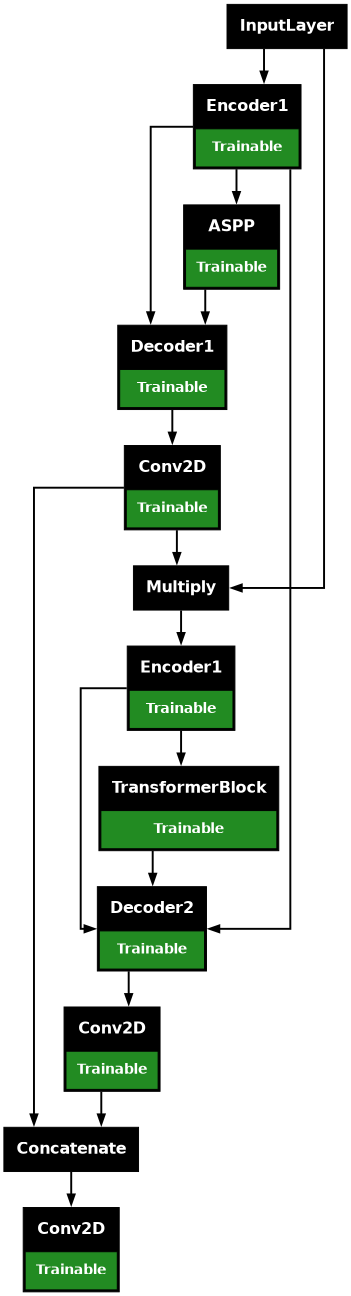

In [25]:
model = build_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [26]:
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback: plot during the training the prediction and the images
#useful for debugging ex. I'm stuck in a local minima where the less represented class is never predicted
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_dataset, frequency=5):
        super().__init__()
        self.val_dataset = val_dataset  # The validation dataset
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            # Get a batch from the validation dataset
            for image_batch, label_batch in self.val_dataset.take(1):
                for i in range(2):
                    idx = 0 if i==0 else 14
                    image = image_batch[idx]  # Take the first image from the batch (oppure 13)
                    label = label_batch[idx]  # Take the first label from the batch
    
                    # Add batch dimension to the image (if necessary)
                    image = tf.expand_dims(image, 0)
    
                    # Perform prediction
                    pred = self.model.predict(image, verbose=0)
                    y_pred = tf.math.argmax(pred, axis=-1)
                    y_pred = y_pred.numpy()  # Convert to NumPy array for visualization
    
                    # Create colormap (assuming a predefined function `create_segmentation_colormap`)
                    num_classes = NUM_CLASSES
                    colormap = create_segmentation_colormap(num_classes)
    
                    # Plot the results
                    plt.figure(figsize=(16, 4))
    
                    # Input image
                    plt.subplot(i+1, 3, 1)
                    plt.imshow(image[0], cmap='gray')
                    plt.title("Input Image")
                    plt.axis('off')
    
                    # Ground truth
                    plt.subplot(i+1, 3, 2)
                    colored_label = apply_colormap(label.numpy(), colormap)  # Assuming `apply_colormap` is defined
                    plt.imshow(colored_label)
                    plt.title("Ground Truth Mask")
                    plt.axis('off')
    
                    # Prediction
                    plt.subplot(i+1, 3, 3)
                    colored_pred = apply_colormap(y_pred[0], colormap)  # Apply colormap to prediction
                    plt.imshow(colored_pred)
                    plt.title("Predicted Mask")
                    plt.axis('off')

                    plt.tight_layout()
                plt.show()
                plt.close()

### class weights

In [27]:
y_train_flatt = y_train.flatten()

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_flatt),
    y=y_train_flatt
)

#class_weights[4] = 30 # adjusting class weight
class_weights = dict(enumerate(class_weights)) 
print("Class weights:", class_weights)

Class weights: {0: 0.8249853953360052, 1: 0.5935027933021484, 2: 0.8366099618482732, 3: 1.1096943312319119, 4: 153.93846875146514}


#### Boundary Loss

In [28]:
# Boudary Loss as expose (SurfaceLoss) in https://github.com/LIVIAETS/boundary-loss/blob/master/losses.py
# code related to https://arxiv.org/abs/1812.07032

class BoundaryLoss(tf.keras.losses.Loss):
    def __init__(self, idc, **kwargs):
        """
        Boundary Loss implementation in TensorFlow.
        Args:
            idc (List[int]): List of class indices to filter out in the target mask.
        """
        super().__init__(**kwargs)
        self.idc = idc  # Classes to exclude
        print(f"Initialized {self.__class__.__name__} with idc={idc}")

    def call(self, probs, dist_maps):
        """
        Compute the boundary loss.
        Args:
            probs (tf.Tensor): Predicted probabilities, shape (batch_size, num_classes, height, width).
            dist_maps (tf.Tensor): Distance maps, shape (batch_size, num_classes, height, width).
        
        Returns:
            tf.Tensor: Scalar loss value.
        """
        # Ensure the inputs are valid
        tf.debugging.assert_less_equal(tf.reduce_max(probs), 1.0, "Probs are not simplex (values > 1)")
        tf.debugging.assert_greater_equal(tf.reduce_min(probs), 0.0, "Probs are not simplex (values < 0)")

        # Exclude the specified classes
        all_classes = tf.range(probs.shape[1])  # All class indices
        include_classes = tf.boolean_mask(all_classes, ~tf.reduce_any(all_classes[..., None] == self.idc, axis=-1))

        # Select only the included classes
        pc = tf.gather(probs, include_classes, axis=1)
        dc = tf.gather(dist_maps, include_classes, axis=1)

        # Perform element-wise multiplication
        multiplied = tf.multiply(pc, dc)

        # Compute mean loss
        loss = multiplied

        return loss

### Dynamic multi-loss

In [29]:
SCCE = tf.keras.losses.SparseCategoricalCrossentropy()
Dice = tf.keras.losses.Dice()
Boundary = BoundaryLoss(idc=[]) #0

'''
adjusts the weights based on the epoch number, 
reducing the Focal loss weight and increasing the Dice loss weight as training progresses.
'''

class DynamicLoss(tf.keras.losses.Loss):
    def __init__(self, **kwargs):
        super(DynamicLoss, self).__init__(**kwargs)
        self.initial_dice_weight = 0.4
        self.initial_scce_weight = 0.4
        self.initial_boundary_weight = 0.2
        
        self.scce_weight = self.initial_scce_weight
        self.dice_weight = self.initial_dice_weight
        self.boundary_weight = self.initial_boundary_weight

    def update_weights(self, epoch):
        total_epochs = EPOCHS
        epoch_factor = epoch / total_epochs
        
        # Adjust weights dynamically
        self.scce_weight = self.initial_scce_weight + epoch_factor * (1 - self.initial_scce_weight)
        self.dice_weight = self.initial_dice_weight - epoch_factor * self.initial_dice_weight
        self.boundary_weight = self.initial_boundary_weight + epoch_factor * (1 - self.initial_boundary_weight)
        
        # Normalize weights so they sum to 1
        total_weight = self.scce_weight +  self.dice_weight + self.boundary_weight
        self.scce_weight /= total_weight
        self.dice_weight /= total_weight
        self.boundary_weight /= total_weight

        print(f"SCCE weight: {self.scce_weight:.4f}, "
              f"Dice weight: {self.dice_weight:.4f}, "
              f"Boundary weight: {self.boundary_weight:.4f}")

    def call(self, y_true, y_pred):

        y_true = tf.cast(y_true, tf.int32)  # Make sure y_true is of type int32
        y_true = tf.squeeze(y_true, axis=-1)  # Remove any extra dimensions (like [batch_size, height, width, 1])
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])  # Convert to one-hot encoding
        y_true = tf.cast(y_true, tf.float32)
        
        # evaluating weights based on classes pixel by pixel, normalized
        class_weights_tensor = tf.constant([class_weights[key] for key in sorted(class_weights.keys())], dtype=tf.float32)

        sample_weights = tf.reduce_sum(class_weights_tensor * y_true, axis=-1)

        # Calculate individual losses
        y_true_indices = tf.argmax(y_true, axis=-1) # sparse categorical cross entropy expect a y_true with y_prede_dim-1
        SCCE_value = SCCE(y_true_indices, y_pred, sample_weight=sample_weights)
        
        Dice_value = Dice(y_true, y_pred)
        Boundary_value = Boundary(y_true, y_pred)

        # Combine losses
        total_loss = self.scce_weight * SCCE_value + self.dice_weight * Dice_value + self.boundary_weight * Boundary_value
        return tf.reduce_mean(total_loss)

Initialized BoundaryLoss with idc=[]


In [30]:
class EpochTracker(tf.keras.callbacks.Callback):
    def __init__(self):
        super(EpochTracker, self).__init__()

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch 
        self.model.loss.update_weights(epoch)
        
    def get_epoch(self):
        return getattr(self, 'epoch', 0) 

In [31]:
# Compile the model
dynamic_loss = DynamicLoss()
# keep track of the epochs for the dynamic_loss updates
epoch_tracker = EpochTracker()

model.compile(
    loss=dynamic_loss, 
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

In [32]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

learning_rate = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=10, 
    min_delta=1e-5,
)

viz_callback = VizCallback(val_dataset, frequency=5)

SCCE weight: 0.4000, Dice weight: 0.4000, Boundary weight: 0.2000
Epoch 1/200


I0000 00:00:1733866339.873038      72 service.cc:145] XLA service 0x7c4fdc0212a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733866339.873121      72 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733866339.873127      72 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1733866347.532555      72 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733866347.534962      72 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/boundary_loss/assert_less_equal/Assert/AssertGuard/Assert
W0000 00:00:1733866347.537701      72 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/boundary_loss/assert_greater_equal/Assert/AssertGuard/Assert
I0000 00:00:1733866361.430912     170 asm_compiler.cc:369] ptxas 

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.1781 - loss: 0.9611 - mean_iou: 0.0616

W0000 00:00:1733866452.925108      73 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733866452.926725      73 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/boundary_loss/assert_less_equal/Assert/AssertGuard/Assert
W0000 00:00:1733866452.928252      73 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/boundary_loss/assert_greater_equal/Assert/AssertGuard/Assert
I0000 00:00:1733866466.357308     242 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_55', 1656 bytes spill stores, 1656 bytes spill loads

I0000 00:00:1733866466.377195     243 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_22', 1020 bytes spill stores, 1020 bytes spill loads

I0000 00:00:1733866472.558323     244 asm_compiler.cc:369] ptxas warning :

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1782 - loss: 0.9614 - mean_iou: 0.0616   

W0000 00:00:1733866523.159749      72 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733866523.162025      72 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/boundary_loss/assert_less_equal/Assert/AssertGuard/Assert
W0000 00:00:1733866523.164771      72 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/boundary_loss/assert_greater_equal/Assert/AssertGuard/Assert
W0000 00:00:1733866533.361040      72 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733866533.362585      72 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/boundary_loss/assert_less_equal/Assert/AssertGuard/Assert
W0000 00:00:1733866533.364168      72 assert_op.cc:38] Ignoring Assert operator compile_loss/dynami

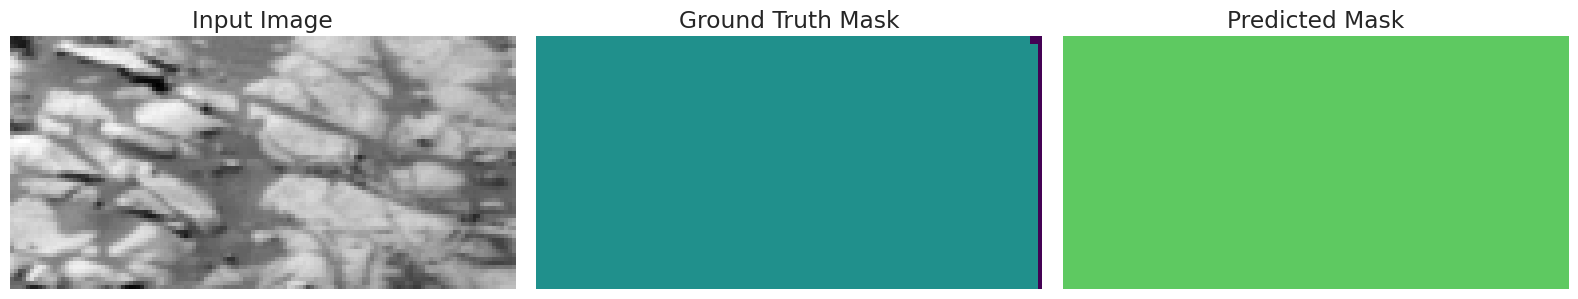

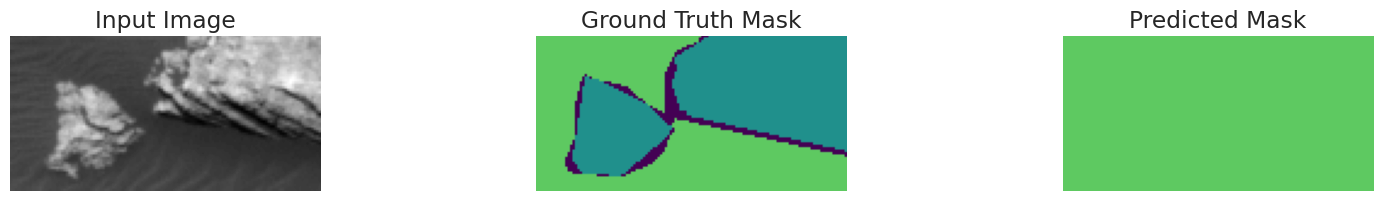

32/32 ━━━━━━━━━━━━━━━━━━━━ 261s 4s/step - accuracy: 0.1782 - loss: 0.9617 - mean_iou: 0.0617 - val_accuracy: 0.1979 - val_loss: 0.9806 - val_mean_iou: 0.0656 - learning_rate: 0.0010
SCCE weight: 0.4010, Dice weight: 0.3960, Boundary weight: 0.2030
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 489ms/step - accuracy: 0.1808 - loss: 0.9703 - mean_iou: 0.0684 - val_accuracy: 0.1979 - val_loss: 0.9797 - val_mean_iou: 0.0656 - learning_rate: 0.0010
SCCE weight: 0.4020, Dice weight: 0.3921, Boundary weight: 0.2059
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 514ms/step - accuracy: 0.2259 - loss: 0.9458 - mean_iou: 0.1075 - val_accuracy: 0.1979 - val_loss: 0.9792 - val_mean_iou: 0.0656 - learning_rate: 0.0010
SCCE weight: 0.4030, Dice weight: 0.3882, Boundary weight: 0.2089
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 507ms/step - accuracy: 0.3505 - loss: 0.9369 - mean_iou: 0.2062 - val_accuracy: 0.3473 - val_loss: 0.9789 - val_mean_iou: 0.1151 - learning_rate: 0.0010
SCCE weight: 0.4039, Dice weight

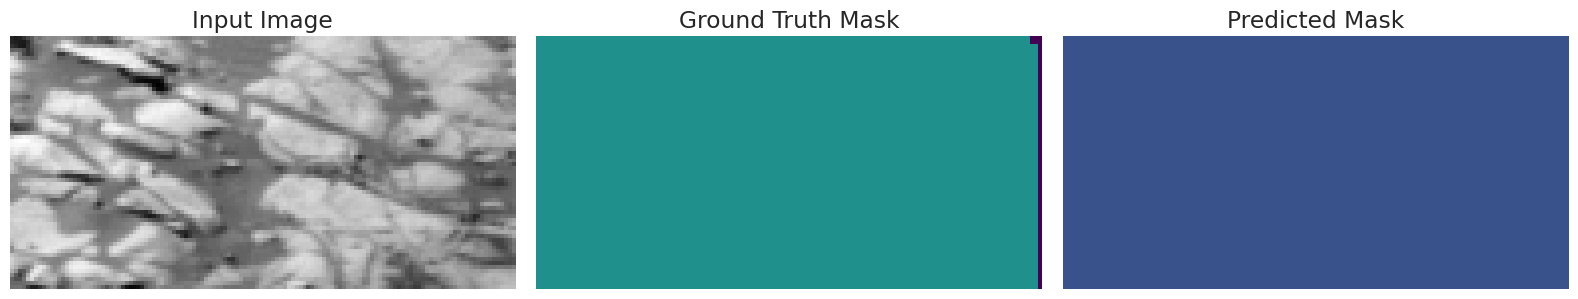

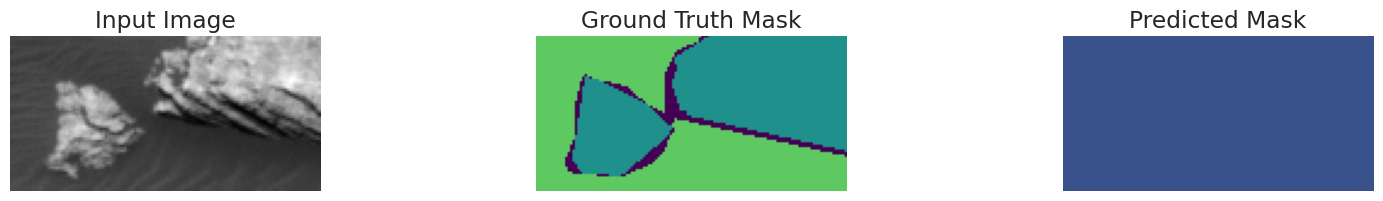

32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 512ms/step - accuracy: 0.4181 - loss: 0.9426 - mean_iou: 0.2782 - val_accuracy: 0.3473 - val_loss: 0.9787 - val_mean_iou: 0.1151 - learning_rate: 0.0010
SCCE weight: 0.4058, Dice weight: 0.3767, Boundary weight: 0.2175
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 488ms/step - accuracy: 0.4345 - loss: 0.9122 - mean_iou: 0.3056 - val_accuracy: 0.3473 - val_loss: 0.9787 - val_mean_iou: 0.1151 - learning_rate: 0.0010
SCCE weight: 0.4068, Dice weight: 0.3729, Boundary weight: 0.2203
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 503ms/step - accuracy: 0.4620 - loss: 0.8996 - mean_iou: 0.3430 - val_accuracy: 0.3463 - val_loss: 0.9777 - val_mean_iou: 0.1556 - learning_rate: 0.0010
SCCE weight: 0.4077, Dice weight: 0.3692, Boundary weight: 0.2231
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 501ms/step - accuracy: 0.4249 - loss: 0.9018 - mean_iou: 0.3042 - val_accuracy: 0.2384 - val_loss: 0.9802 - val_mean_iou: 0.1043 - learning_rate: 0.0010
SCCE weight: 0.4086, Dice weig

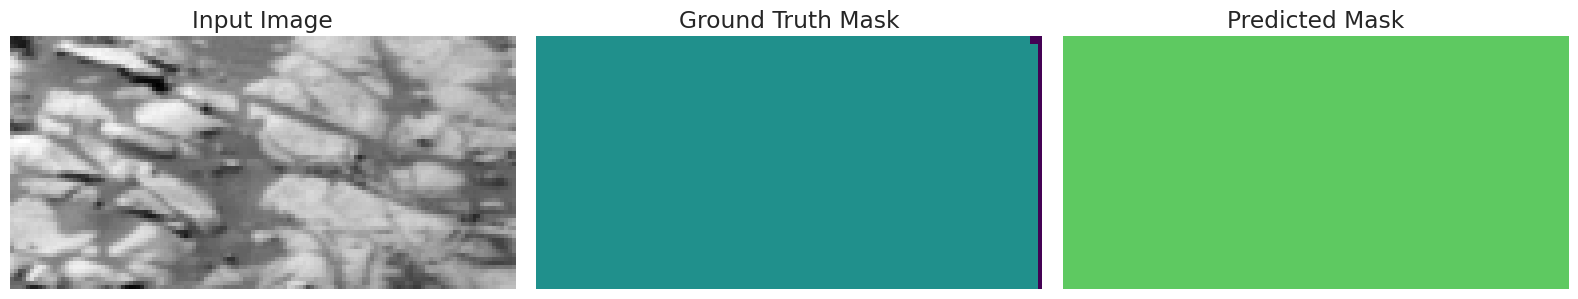

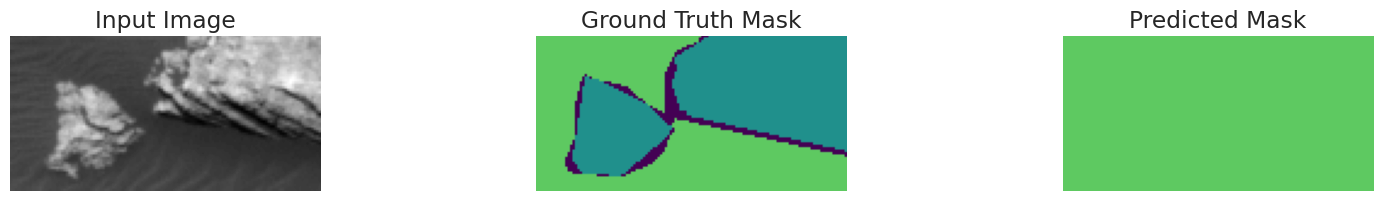

32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 527ms/step - accuracy: 0.4350 - loss: 0.9021 - mean_iou: 0.2730 - val_accuracy: 0.2499 - val_loss: 0.9880 - val_mean_iou: 0.1140 - learning_rate: 0.0010
SCCE weight: 0.4104, Dice weight: 0.3583, Boundary weight: 0.2313
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 489ms/step - accuracy: 0.4415 - loss: 0.8805 - mean_iou: 0.2642 - val_accuracy: 0.2462 - val_loss: 0.9959 - val_mean_iou: 0.1104 - learning_rate: 0.0010
SCCE weight: 0.4113, Dice weight: 0.3547, Boundary weight: 0.2340
Epoch 13/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 490ms/step - accuracy: 0.4415 - loss: 0.8586 - mean_iou: 0.2622 - val_accuracy: 0.1979 - val_loss: 1.0041 - val_mean_iou: 0.0656 - learning_rate: 0.0010
SCCE weight: 0.4122, Dice weight: 0.3512, Boundary weight: 0.2366
Epoch 14/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 491ms/step - accuracy: 0.4287 - loss: 0.8614 - mean_iou: 0.2499 - val_accuracy: 0.1982 - val_loss: 1.0198 - val_mean_iou: 0.0659 - learning_rate: 0.0010
SCCE weight: 0.4131, Dice w

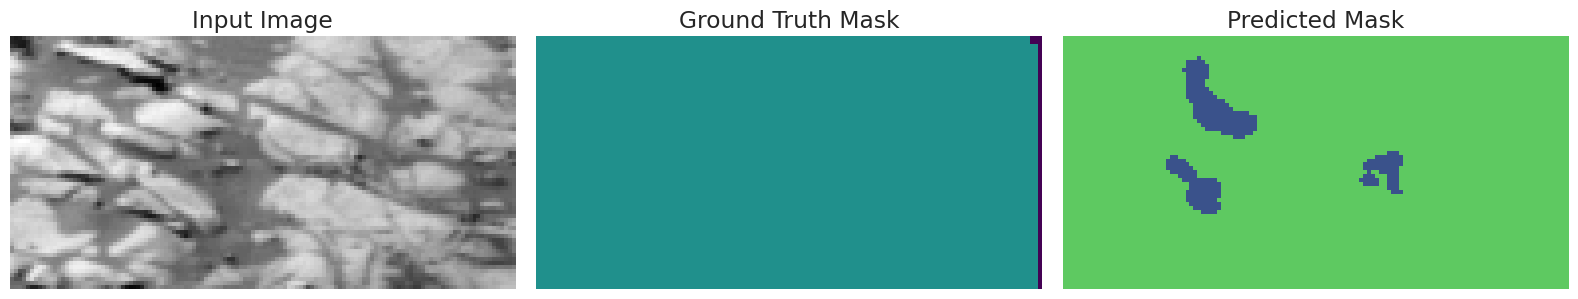

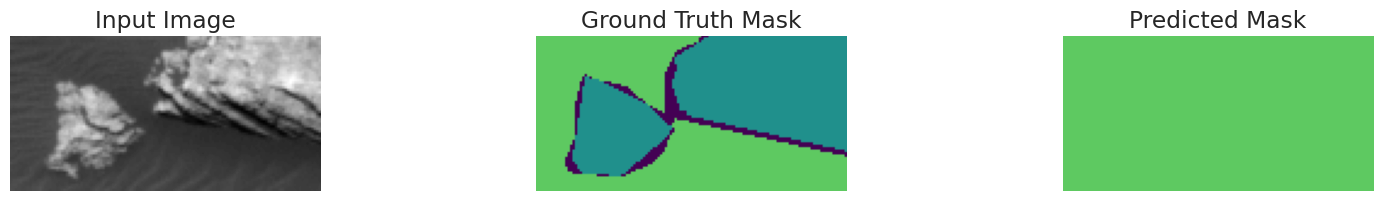

32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 529ms/step - accuracy: 0.4680 - loss: 0.8258 - mean_iou: 0.2825 - val_accuracy: 0.2061 - val_loss: 1.0264 - val_mean_iou: 0.0589 - learning_rate: 0.0010
SCCE weight: 0.4148, Dice weight: 0.3407, Boundary weight: 0.2444
Epoch 17/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 498ms/step - accuracy: 0.4157 - loss: 0.8539 - mean_iou: 0.2345 - val_accuracy: 0.3201 - val_loss: 0.9415 - val_mean_iou: 0.1584 - learning_rate: 0.0010
SCCE weight: 0.4157, Dice weight: 0.3373, Boundary weight: 0.2470
Epoch 18/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 494ms/step - accuracy: 0.3787 - loss: 0.8872 - mean_iou: 0.1853 - val_accuracy: 0.1995 - val_loss: 1.0548 - val_mean_iou: 0.0546 - learning_rate: 0.0010
SCCE weight: 0.4165, Dice weight: 0.3339, Boundary weight: 0.2495
Epoch 19/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 494ms/step - accuracy: 0.3805 - loss: 0.9109 - mean_iou: 0.1823 - val_accuracy: 0.1926 - val_loss: 0.9969 - val_mean_iou: 0.0587 - learning_rate: 0.0010
SCCE weight: 0.4174, Dice w

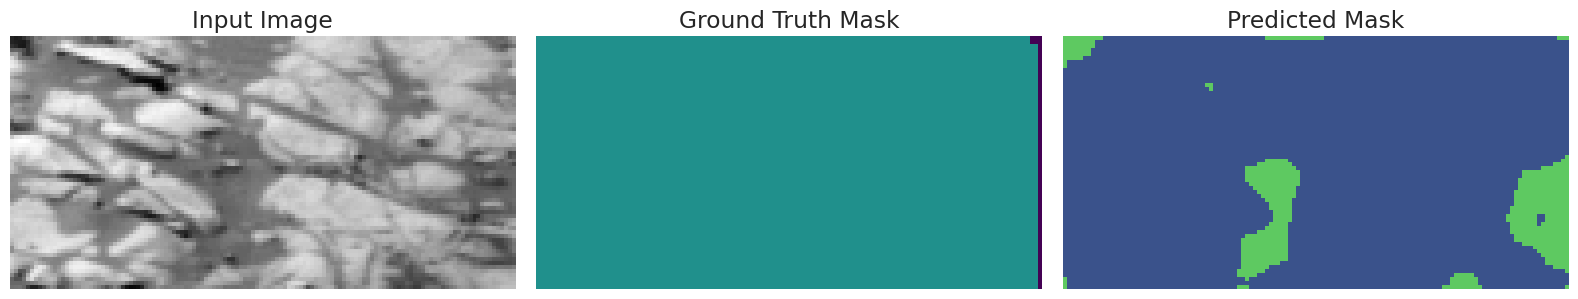

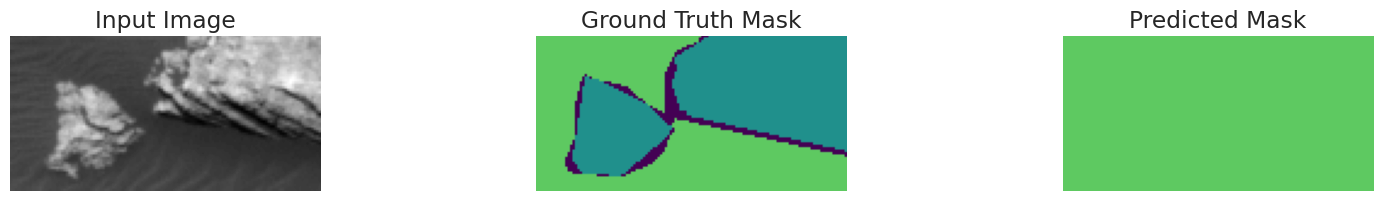

32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 532ms/step - accuracy: 0.4107 - loss: 0.8666 - mean_iou: 0.2102 - val_accuracy: 0.3099 - val_loss: 0.9088 - val_mean_iou: 0.1432 - learning_rate: 0.0010
SCCE weight: 0.4190, Dice weight: 0.3240, Boundary weight: 0.2570
Epoch 22/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 494ms/step - accuracy: 0.4135 - loss: 0.8533 - mean_iou: 0.2219 - val_accuracy: 0.3332 - val_loss: 0.8890 - val_mean_iou: 0.1672 - learning_rate: 0.0010
SCCE weight: 0.4198, Dice weight: 0.3207, Boundary weight: 0.2595
Epoch 23/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 496ms/step - accuracy: 0.3976 - loss: 0.8659 - mean_iou: 0.2105 - val_accuracy: 0.3444 - val_loss: 0.8832 - val_mean_iou: 0.1709 - learning_rate: 0.0010
SCCE weight: 0.4206, Dice weight: 0.3175, Boundary weight: 0.2619
Epoch 24/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 496ms/step - accuracy: 0.4013 - loss: 0.8581 - mean_iou: 0.2126 - val_accuracy: 0.3546 - val_loss: 0.8689 - val_mean_iou: 0.1810 - learning_rate: 0.0010
SCCE weight: 0.4214, Dice w

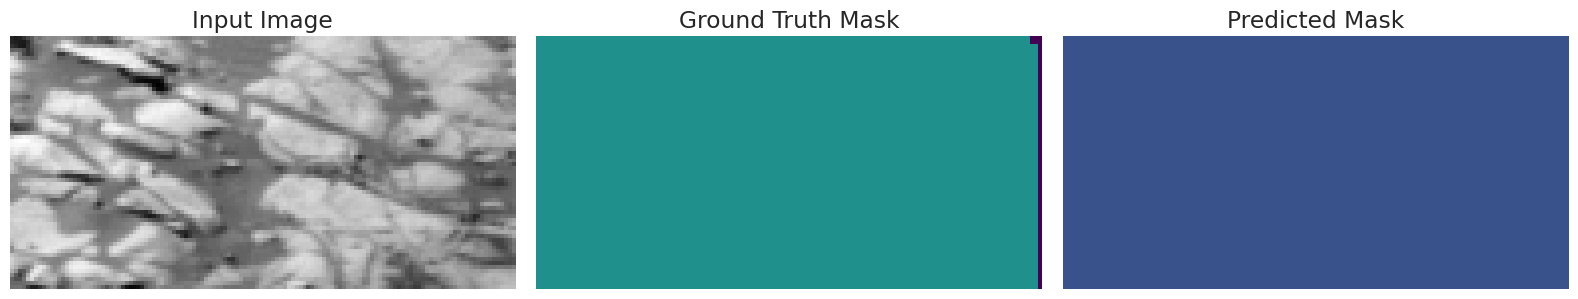

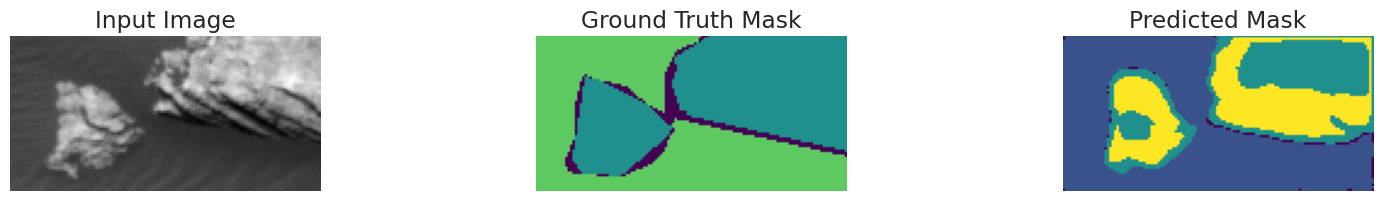

32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 534ms/step - accuracy: 0.4169 - loss: 0.8345 - mean_iou: 0.2252 - val_accuracy: 0.4374 - val_loss: 0.8650 - val_mean_iou: 0.2222 - learning_rate: 0.0010
SCCE weight: 0.4230, Dice weight: 0.3080, Boundary weight: 0.2690
Epoch 27/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 491ms/step - accuracy: 0.4451 - loss: 0.8133 - mean_iou: 0.2431 - val_accuracy: 0.4108 - val_loss: 0.8645 - val_mean_iou: 0.2074 - learning_rate: 0.0010
SCCE weight: 0.4238, Dice weight: 0.3048, Boundary weight: 0.2714
Epoch 28/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 496ms/step - accuracy: 0.4522 - loss: 0.8084 - mean_iou: 0.2463 - val_accuracy: 0.4328 - val_loss: 0.8383 - val_mean_iou: 0.2344 - learning_rate: 0.0010
SCCE weight: 0.4246, Dice weight: 0.3018, Boundary weight: 0.2737
Epoch 29/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 492ms/step - accuracy: 0.4486 - loss: 0.8078 - mean_iou: 0.2491 - val_accuracy: 0.4178 - val_loss: 0.8519 - val_mean_iou: 0.2250 - learning_rate: 0.0010
SCCE weight: 0.4253, Dice w

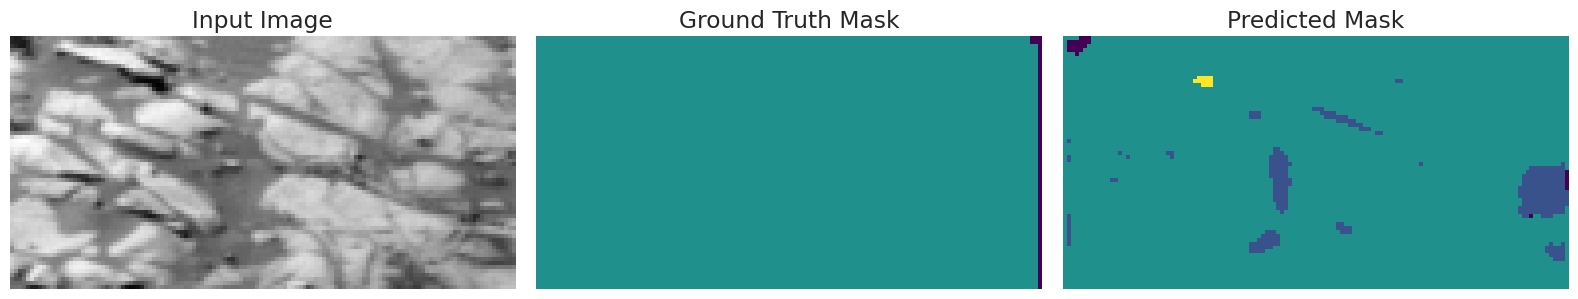

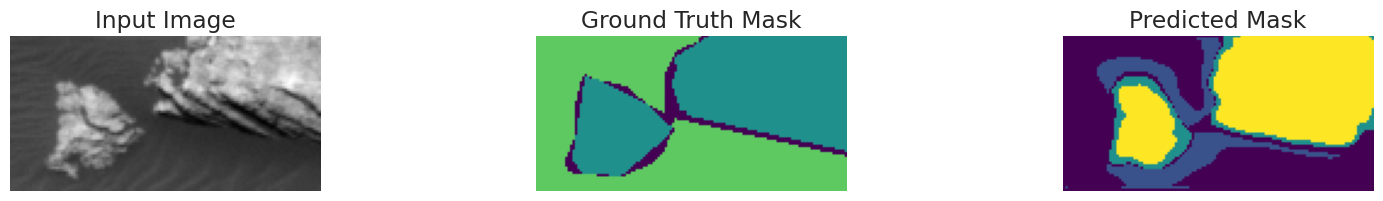

32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 529ms/step - accuracy: 0.4664 - loss: 0.8005 - mean_iou: 0.2600 - val_accuracy: 0.4160 - val_loss: 0.8612 - val_mean_iou: 0.2138 - learning_rate: 0.0010
SCCE weight: 0.4268, Dice weight: 0.2926, Boundary weight: 0.2805
Epoch 32/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 491ms/step - accuracy: 0.4687 - loss: 0.7789 - mean_iou: 0.2516 - val_accuracy: 0.4670 - val_loss: 0.8212 - val_mean_iou: 0.2403 - learning_rate: 0.0010
SCCE weight: 0.4276, Dice weight: 0.2897, Boundary weight: 0.2828
Epoch 33/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 494ms/step - accuracy: 0.4452 - loss: 0.8000 - mean_iou: 0.2327 - val_accuracy: 0.4747 - val_loss: 0.8138 - val_mean_iou: 0.2544 - learning_rate: 0.0010
SCCE weight: 0.4283, Dice weight: 0.2867, Boundary weight: 0.2850
Epoch 34/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 491ms/step - accuracy: 0.4688 - loss: 0.7795 - mean_iou: 0.2527 - val_accuracy: 0.4633 - val_loss: 0.8162 - val_mean_iou: 0.2339 - learning_rate: 0.0010
SCCE weight: 0.4291, Dice w

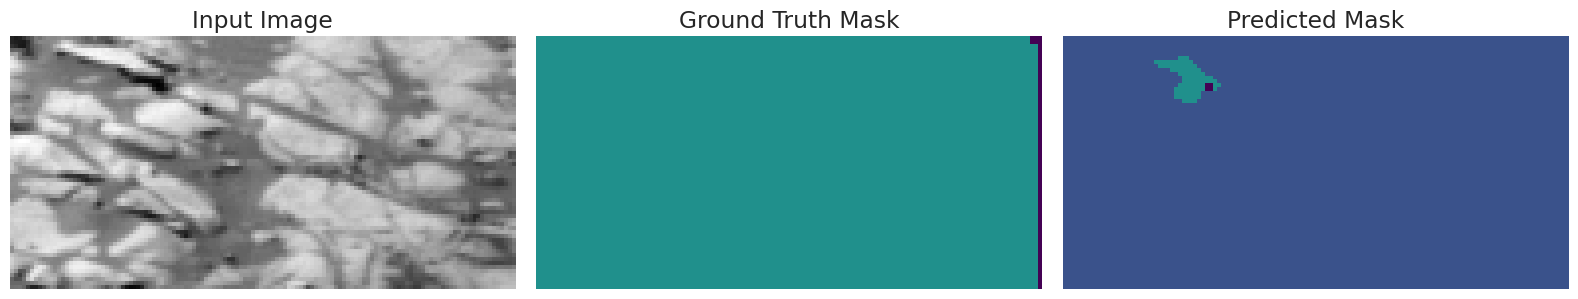

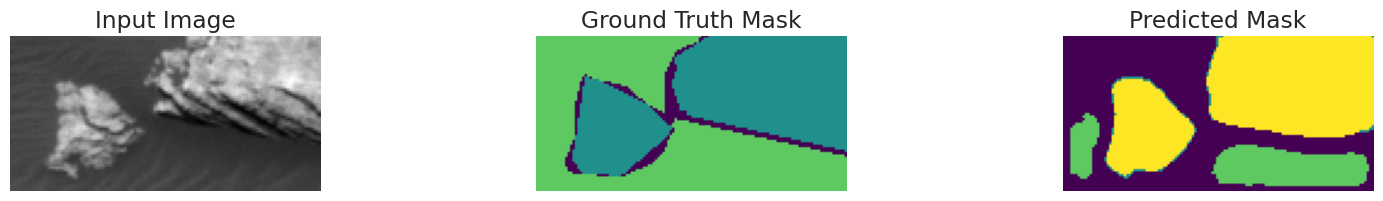

32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 526ms/step - accuracy: 0.4399 - loss: 0.7903 - mean_iou: 0.2319 - val_accuracy: 0.4660 - val_loss: 0.8318 - val_mean_iou: 0.2369 - learning_rate: 0.0010
SCCE weight: 0.4305, Dice weight: 0.2780, Boundary weight: 0.2915
Epoch 37/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 491ms/step - accuracy: 0.4820 - loss: 0.7680 - mean_iou: 0.2511 - val_accuracy: 0.4695 - val_loss: 0.8232 - val_mean_iou: 0.2299 - learning_rate: 0.0010
SCCE weight: 0.4312, Dice weight: 0.2751, Boundary weight: 0.2937
Epoch 38/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 491ms/step - accuracy: 0.4874 - loss: 0.7519 - mean_iou: 0.2614 - val_accuracy: 0.4463 - val_loss: 0.8375 - val_mean_iou: 0.2092 - learning_rate: 0.0010
SCCE weight: 0.4319, Dice weight: 0.2723, Boundary weight: 0.2958
Epoch 39/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 492ms/step - accuracy: 0.4995 - loss: 0.7534 - mean_iou: 0.2773 - val_accuracy: 0.4858 - val_loss: 0.7949 - val_mean_iou: 0.2396 - learning_rate: 0.0010
SCCE weight: 0.4326, Dice w

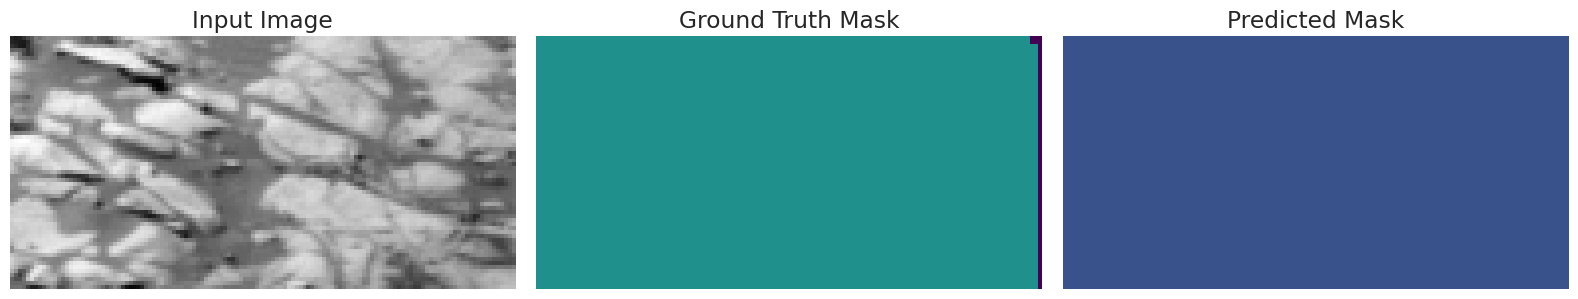

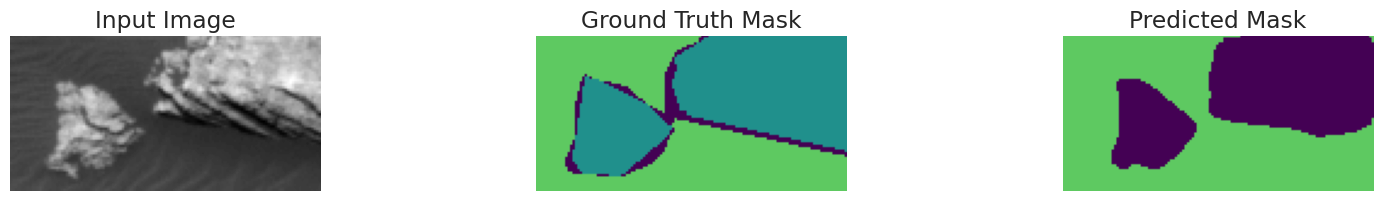

32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 525ms/step - accuracy: 0.5014 - loss: 0.7513 - mean_iou: 0.2728 - val_accuracy: 0.4992 - val_loss: 0.7764 - val_mean_iou: 0.2465 - learning_rate: 0.0010
SCCE weight: 0.4340, Dice weight: 0.2639, Boundary weight: 0.3021
Epoch 42/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 494ms/step - accuracy: 0.5095 - loss: 0.7392 - mean_iou: 0.2794 - val_accuracy: 0.5106 - val_loss: 0.7697 - val_mean_iou: 0.2604 - learning_rate: 0.0010
SCCE weight: 0.4347, Dice weight: 0.2612, Boundary weight: 0.3041
Epoch 43/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 495ms/step - accuracy: 0.5086 - loss: 0.7374 - mean_iou: 0.2825 - val_accuracy: 0.5334 - val_loss: 0.7392 - val_mean_iou: 0.2813 - learning_rate: 0.0010
SCCE weight: 0.4354, Dice weight: 0.2584, Boundary weight: 0.3062
Epoch 44/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 493ms/step - accuracy: 0.5250 - loss: 0.7244 - mean_iou: 0.2969 - val_accuracy: 0.5006 - val_loss: 0.7365 - val_mean_iou: 0.2619 - learning_rate: 0.0010
SCCE weight: 0.4361, Dice w

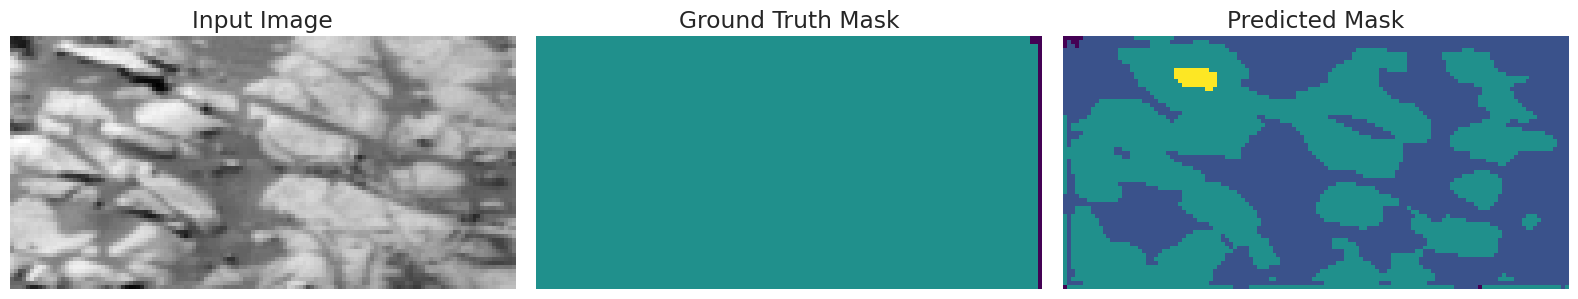

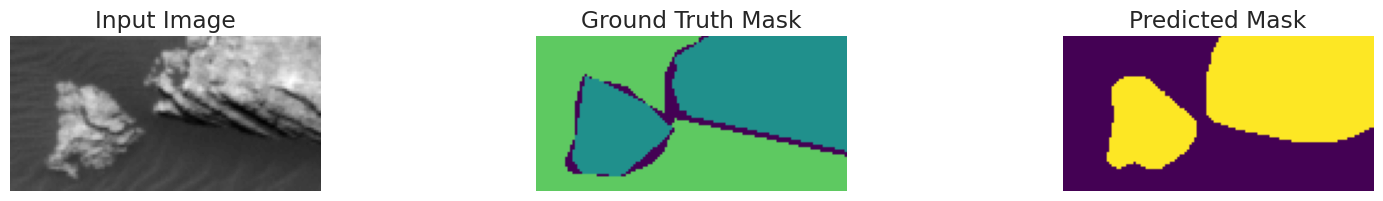

32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 525ms/step - accuracy: 0.5006 - loss: 0.7370 - mean_iou: 0.2785 - val_accuracy: 0.4791 - val_loss: 0.7419 - val_mean_iou: 0.2743 - learning_rate: 0.0010
SCCE weight: 0.4374, Dice weight: 0.2504, Boundary weight: 0.3122
Epoch 47/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 490ms/step - accuracy: 0.5010 - loss: 0.7359 - mean_iou: 0.2759 - val_accuracy: 0.4705 - val_loss: 0.7666 - val_mean_iou: 0.2759 - learning_rate: 0.0010
SCCE weight: 0.4381, Dice weight: 0.2478, Boundary weight: 0.3142
Epoch 48/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 488ms/step - accuracy: 0.5016 - loss: 0.7236 - mean_iou: 0.2885 - val_accuracy: 0.5102 - val_loss: 0.7482 - val_mean_iou: 0.2784 - learning_rate: 0.0010
SCCE weight: 0.4387, Dice weight: 0.2452, Boundary weight: 0.3161
Epoch 49/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 489ms/step - accuracy: 0.5063 - loss: 0.7184 - mean_iou: 0.2845 - val_accuracy: 0.5261 - val_loss: 0.7145 - val_mean_iou: 0.2973 - learning_rate: 0.0010
SCCE weight: 0.4394, Dice w

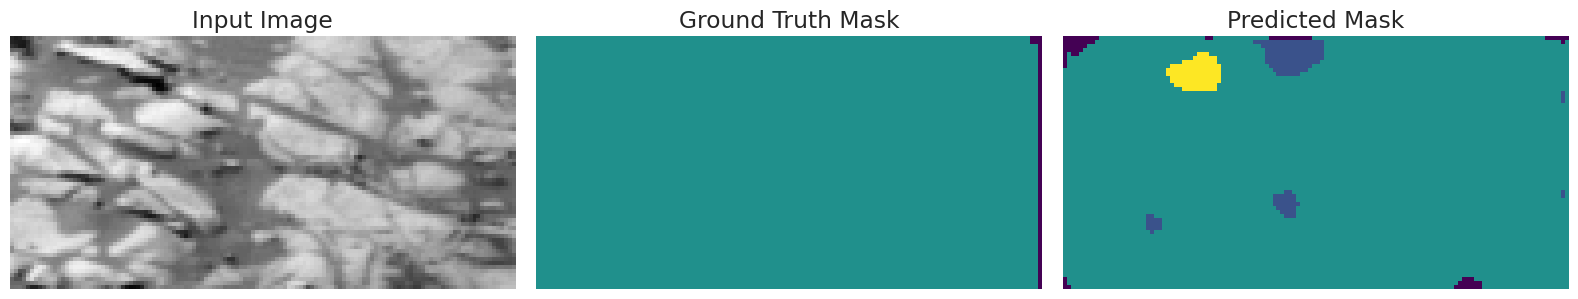

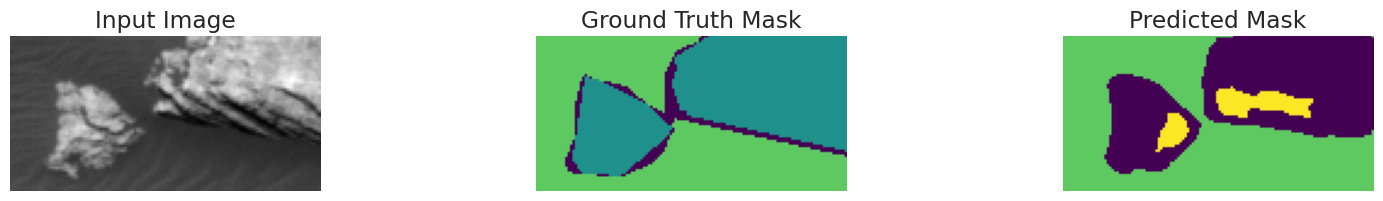

32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 529ms/step - accuracy: 0.5169 - loss: 0.7095 - mean_iou: 0.2913 - val_accuracy: 0.5430 - val_loss: 0.7133 - val_mean_iou: 0.3047 - learning_rate: 0.0010
SCCE weight: 0.4406, Dice weight: 0.2375, Boundary weight: 0.3219
Epoch 52/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 488ms/step - accuracy: 0.4947 - loss: 0.7172 - mean_iou: 0.2694 - val_accuracy: 0.5161 - val_loss: 0.7169 - val_mean_iou: 0.2824 - learning_rate: 0.0010
SCCE weight: 0.4413, Dice weight: 0.2349, Boundary weight: 0.3238
Epoch 53/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 491ms/step - accuracy: 0.5225 - loss: 0.6965 - mean_iou: 0.2944 - val_accuracy: 0.5499 - val_loss: 0.7114 - val_mean_iou: 0.2994 - learning_rate: 0.0010
SCCE weight: 0.4419, Dice weight: 0.2324, Boundary weight: 0.3257
Epoch 54/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 490ms/step - accuracy: 0.5322 - loss: 0.6917 - mean_iou: 0.3021 - val_accuracy: 0.5473 - val_loss: 0.7274 - val_mean_iou: 0.3003 - learning_rate: 0.0010
SCCE weight: 0.4425, Dice w

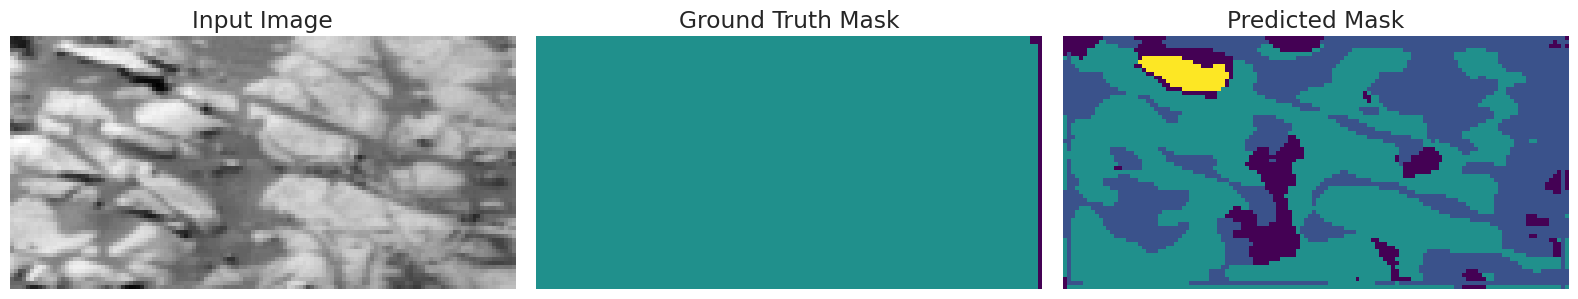

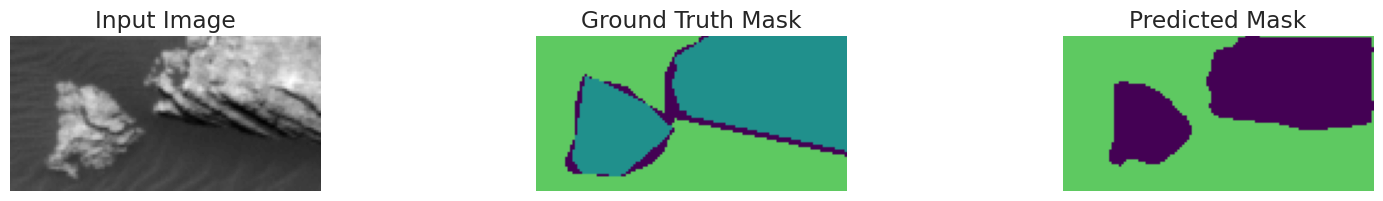

32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 529ms/step - accuracy: 0.5410 - loss: 0.6913 - mean_iou: 0.3082 - val_accuracy: 0.5144 - val_loss: 0.7376 - val_mean_iou: 0.2549 - learning_rate: 0.0010
SCCE weight: 0.4437, Dice weight: 0.2250, Boundary weight: 0.3312
Epoch 57/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 490ms/step - accuracy: 0.5500 - loss: 0.6850 - mean_iou: 0.3125 - val_accuracy: 0.5088 - val_loss: 0.7487 - val_mean_iou: 0.2652 - learning_rate: 0.0010
SCCE weight: 0.4444, Dice weight: 0.2226, Boundary weight: 0.3331
Epoch 58/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 489ms/step - accuracy: 0.5490 - loss: 0.6748 - mean_iou: 0.3185 - val_accuracy: 0.5450 - val_loss: 0.7147 - val_mean_iou: 0.2944 - learning_rate: 0.0010
SCCE weight: 0.4450, Dice weight: 0.2202, Boundary weight: 0.3349
Epoch 59/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 493ms/step - accuracy: 0.5620 - loss: 0.6783 - mean_iou: 0.3300 - val_accuracy: 0.5523 - val_loss: 0.7108 - val_mean_iou: 0.3128 - learning_rate: 0.0010
SCCE weight: 0.4456, Dice w

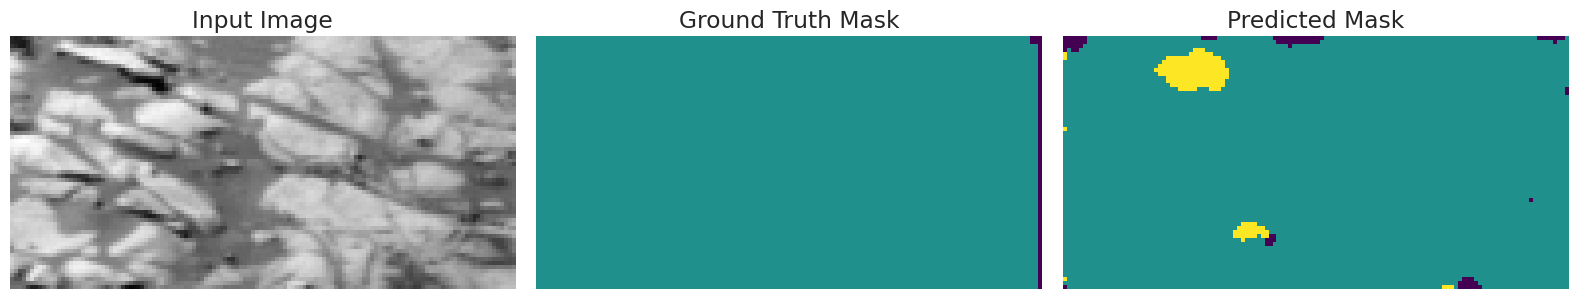

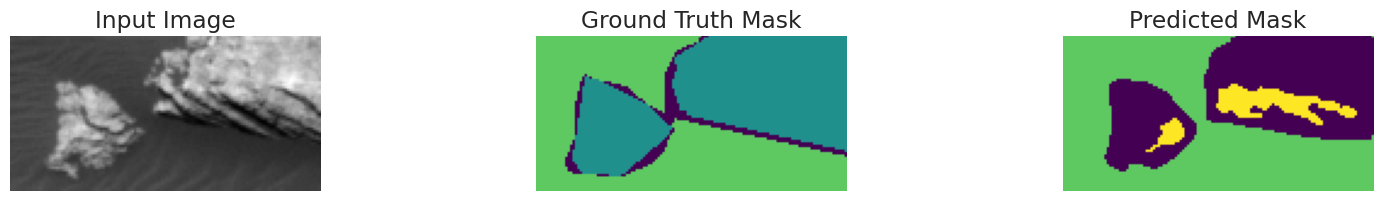

32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 550ms/step - accuracy: 0.5602 - loss: 0.6773 - mean_iou: 0.3256 - val_accuracy: 0.5792 - val_loss: 0.6740 - val_mean_iou: 0.3387 - learning_rate: 0.0010
SCCE weight: 0.4467, Dice weight: 0.2130, Boundary weight: 0.3402
Epoch 62/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 490ms/step - accuracy: 0.5678 - loss: 0.6662 - mean_iou: 0.3293 - val_accuracy: 0.5794 - val_loss: 0.6889 - val_mean_iou: 0.3318 - learning_rate: 0.0010
SCCE weight: 0.4473, Dice weight: 0.2107, Boundary weight: 0.3420
Epoch 63/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 490ms/step - accuracy: 0.5488 - loss: 0.6913 - mean_iou: 0.3168 - val_accuracy: 0.4805 - val_loss: 0.7706 - val_mean_iou: 0.2548 - learning_rate: 0.0010
SCCE weight: 0.4479, Dice weight: 0.2084, Boundary weight: 0.3437
Epoch 64/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 493ms/step - accuracy: 0.5509 - loss: 0.6865 - mean_iou: 0.3169 - val_accuracy: 0.2150 - val_loss: 1.2205 - val_mean_iou: 0.0643 - learning_rate: 0.0010
SCCE weight: 0.4485, Dice w

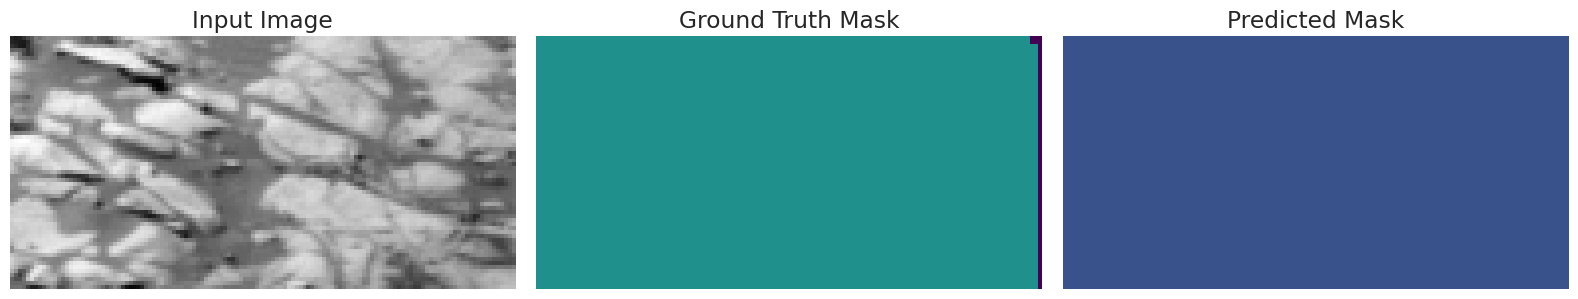

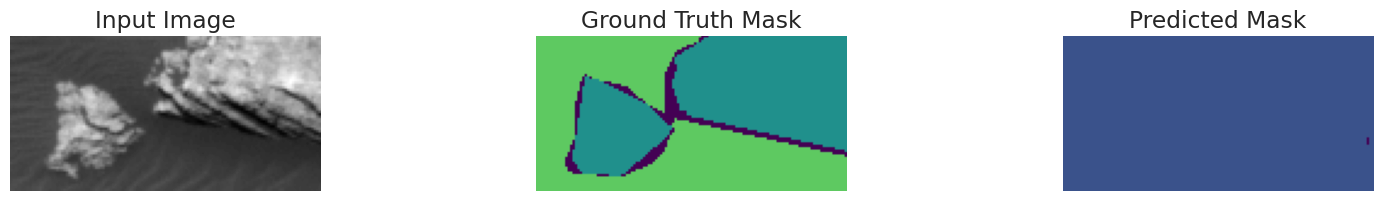

32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 523ms/step - accuracy: 0.3598 - loss: 0.8894 - mean_iou: 0.1492 - val_accuracy: 0.3552 - val_loss: 1.0877 - val_mean_iou: 0.1156 - learning_rate: 0.0010
SCCE weight: 0.4496, Dice weight: 0.2015, Boundary weight: 0.3489
Epoch 67/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 483ms/step - accuracy: 0.3608 - loss: 0.8594 - mean_iou: 0.1582 - val_accuracy: 0.3120 - val_loss: 0.9438 - val_mean_iou: 0.1273 - learning_rate: 0.0010
SCCE weight: 0.4502, Dice weight: 0.1993, Boundary weight: 0.3506
Epoch 68/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 489ms/step - accuracy: 0.3436 - loss: 0.8567 - mean_iou: 0.1525 - val_accuracy: 0.2435 - val_loss: 0.9478 - val_mean_iou: 0.0812 - learning_rate: 0.0010
SCCE weight: 0.4507, Dice weight: 0.1970, Boundary weight: 0.3522
Epoch 69/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 494ms/step - accuracy: 0.3743 - loss: 0.8372 - mean_iou: 0.1806 - val_accuracy: 0.2080 - val_loss: 0.9499 - val_mean_iou: 0.0709 - learning_rate: 0.0010
SCCE weight: 0.4513, Dice w

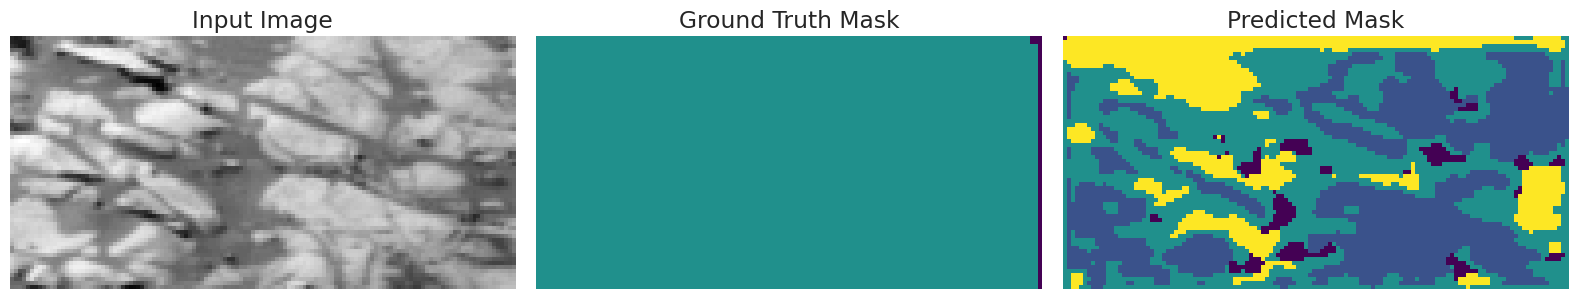

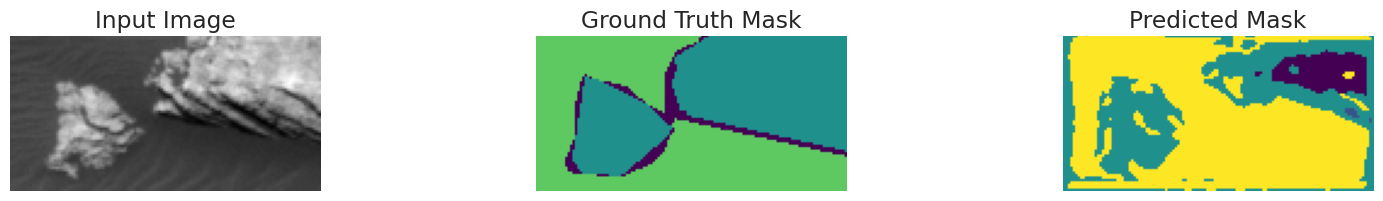

32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 526ms/step - accuracy: 0.3968 - loss: 0.8333 - mean_iou: 0.1922 - val_accuracy: 0.2350 - val_loss: 0.9640 - val_mean_iou: 0.0877 - learning_rate: 0.0010
SCCE weight: 0.4524, Dice weight: 0.1904, Boundary weight: 0.3572
Epoch 72/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 486ms/step - accuracy: 0.4174 - loss: 0.8032 - mean_iou: 0.2014 - val_accuracy: 0.3042 - val_loss: 0.9362 - val_mean_iou: 0.1105 - learning_rate: 1.0000e-04
SCCE weight: 0.4529, Dice weight: 0.1882, Boundary weight: 0.3588
Epoch 73/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 491ms/step - accuracy: 0.4263 - loss: 0.8029 - mean_iou: 0.2132 - val_accuracy: 0.3420 - val_loss: 0.8885 - val_mean_iou: 0.1363 - learning_rate: 1.0000e-04
SCCE weight: 0.4535, Dice weight: 0.1861, Boundary weight: 0.3604
Epoch 74/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 492ms/step - accuracy: 0.4359 - loss: 0.7952 - mean_iou: 0.2189 - val_accuracy: 0.3835 - val_loss: 0.8590 - val_mean_iou: 0.1726 - learning_rate: 1.0000e-04
SCCE weight: 0.

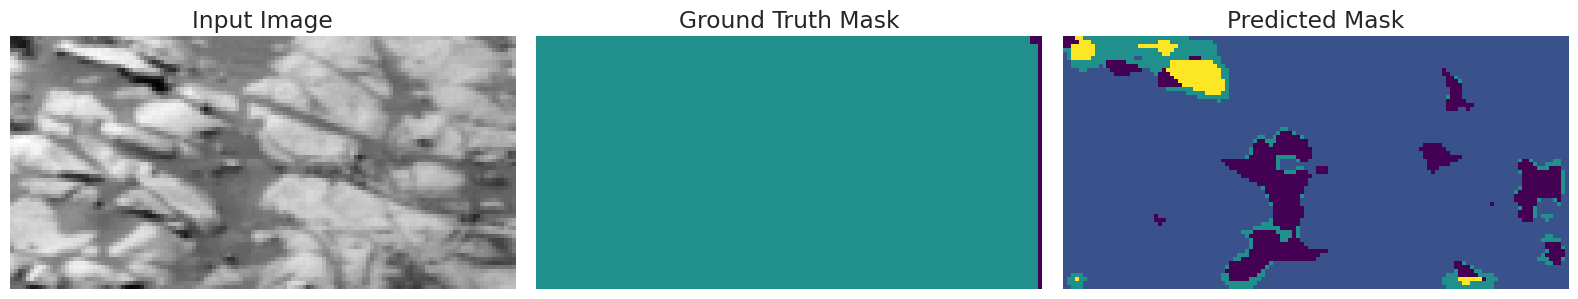

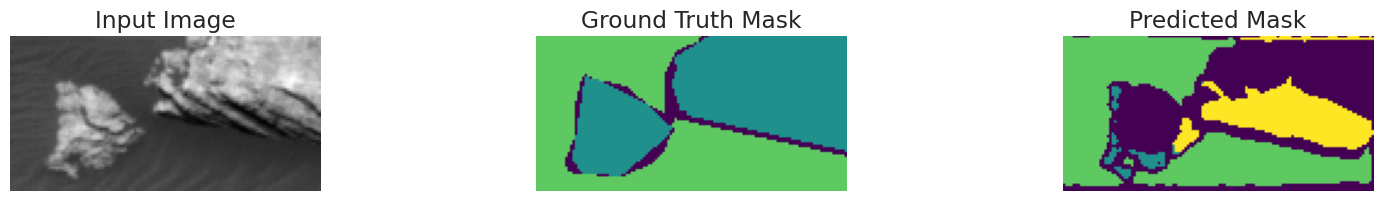

32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 530ms/step - accuracy: 0.4262 - loss: 0.7899 - mean_iou: 0.2127 - val_accuracy: 0.4001 - val_loss: 0.8316 - val_mean_iou: 0.1878 - learning_rate: 1.0000e-04
SCCE weight: 0.4551, Dice weight: 0.1797, Boundary weight: 0.3652
Epoch 77/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 490ms/step - accuracy: 0.4250 - loss: 0.8022 - mean_iou: 0.2142 - val_accuracy: 0.4250 - val_loss: 0.8059 - val_mean_iou: 0.2100 - learning_rate: 1.0000e-04
SCCE weight: 0.4556, Dice weight: 0.1776, Boundary weight: 0.3668
Epoch 78/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.4342 - loss: 0.7909 - mean_iou: 0.2183

In [ ]:
# Train the model
history = model.fit( 
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, learning_rate, epoch_tracker, viz_callback],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file 
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)

print(f"Model saved to {model_filename}")

#del model

In [ ]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 🔮 Predictions on the Test Set

In [ ]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [ ]:
'''
model = tfk.models.load_model(model_filename, compile=False)
print(f"Model loaded from {model_filename}")
'''

In [ ]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

In [ ]:
# Plot some predictions 
num_samples = 8
# Only take the first `num_samples` from X_test and preds
images = X_test[:num_samples]
predictions = preds[:num_samples]

# Adjust the number of classes to match the actual classes in the predictions (excluding 0)
num_classes = len(classes) # Excluding background

# Create colormap based on the number of classes
colormap = create_segmentation_colormap(num_classes)

# Create a list to store the handles for the legend (only once)
handles = []

for i in range(num_samples):
    # Get the i-th image and its prediction
    image = images[i]
    predicted_mask = predictions[i]

    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot original image
    axes[0].set_title("Original Image")
    axes[0].imshow(image, cmap='gray')
    axes[0].axis('off')

    # Plot predicted mask
    axes[1].set_title("Predicted Mask")
    colored_pred = apply_colormap(predicted_mask, colormap)
    axes[1].imshow(colored_pred)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

# After all images have been plotted, add the legend once
# We collect handles for the legend here, only once
for label_idx in category_map: 
    color = colormap[label_idx]  # Use array indexing, subtracting 1 to account for class 0 exclusion
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=classes[label_idx]))

# Create a single legend displayed at the bottom
fig, ax = plt.subplots(figsize=(10, 2))  # Make the figure wide enough for a horizontal legend
ax.legend(handles=handles, loc='center', bbox_to_anchor=(0.5, 0), title="Classes", ncol=len(category_map))
ax.axis('off')
plt.show()

In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

In [ ]:
del model